# Crawling Tiki main categories and sub categories

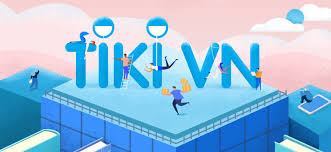

This notebook will guide you to use python function recursively to crawl main categories. For each main categories, it will start to crawl links for sub categories. Recursively, each sub categories have deeper levels of sub categories( Main -> level 2 -> level 3 -> level 4 -> ... ? ) = How deep can it go -> Inception!!!

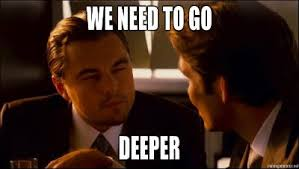

Since we don't know how many level of sub categories and how deep for each categories, we need to use recursion to solve this problem.

All of these category links will be saved in a SQLite database.
After crawling all categories (main and subs), you can use your previous weekly project function to crawl products for each of categories to get to get as many products as possible.

At the end of the day, this notebook only crawl links of categories. Therefore, crawling products is your task for the weekly project.

In [1]:
# install selenium and other resources for crawling data
!pip install selenium
# install other resources for doing crawling
!apt install chromium-chromedriver

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from time import sleep
from random import randint
import json
import re
import time

from selenium import webdriver
# Set driver for Chrome
options = webdriver.ChromeOptions()
options.add_argument('-headless') # since we run selenium on Google Colab so we don't want a chrome browser opens, so it will run in the background
options.add_argument('-no-sandbox')

In [34]:
def get_url(url):
    driver = webdriver.Chrome('chromedriver',options=options)        # Define the chrome drivers with setting options we define above    
    # we let selenium to wait for 30 seconds for all javascript script done before return the result of HTML
    driver.implicitly_wait(30) 
    driver.get(url)                                             # Open the browser again to get web page
    html_data = driver.page_source                                   # After driver.get() is done, you can get back HTML string by using .page_source
    driver.close()                                                   # Close the driver after retrieving the web page
    time.sleep(5)
    soup = BeautifulSoup(html_data, 'html.parser') 

    return soup

In [35]:
def extract_tiki_info(url):
  """ Extract info from all products of a specfic category on Tiki website
      Input: url
      Output: info of products, saved as list of dictionary. If no products shown, return empty list.
  """
  data = []
  index = 1
  soup = get_url(url)

  # FIND ALL PRODUCT ITEMS
  products = soup.find_all('a', {'class':'product-item'})
  all_script = soup.find_all('script', {'type':'application/ld+json'})
  print("BATCH SIZE:", len(products))

  if (soup.find('div', {'class':'style__StyledNotFoundProductView-sc-1uz0b49-0'})):
    print("END PAGE")
  elif len(products):
    # EXTRACT INFO TO DICTIONARY
    for i in products: 
      d = {'name':'','price':'','product_url':'','image':'', 'product_sku':'',
           'tiki_now':'','freeship':'','review':'','rating':'','under_price':'',
           'discount':'','installment':'','gift':''}
      
      try:
        d['name']         = i.find('div',{'class' : 'name'}).text
        d['price']        = int(re.sub('[. ₫]','', i.find('div',{'class':'price-discount__price'}).text))
        d['product_url']  = 'https://tiki.vn' + i['href'] 
        thumbnail         = i.find('div',{'class':'thumbnail'})
        d['image']        = thumbnail.img['src']        
        d['tiki_now']     = bool(i.find('div',{'class':'badge-service'}).find('div',{'class':'item'})) 
        d['freeship']     = bool(i.find('div',{'class':'badge-top'}).text == "Freeship")
        
        if i.find('div',{'class':'review'}):
          d['review']     = int(i.find('div',{'class':'review'}).text.strip('(').strip(')'))
        else:
          d['review'] = "N/A"
        
        d['under_price']  = bool(i.find('div',{'class':'badge-under-price'}).find('div',{'class':'item'}))

        if i.find('div', {'class':'price-discount__discount'}):
          d['discount']   = int(re.sub('[-%]','', i.find('div',{'class':'price-discount__discount'}).text))
        else:
          d['discount']   = "N/A"
        
        d['installment']  = bool(i.find('div',{'class':'badge-benefits'}).img)
        d['gift']         = bool(i.find('div',{'class':'freegift-list'}))

        script = all_script[index]
        dict_content = json.loads(script.text)
        d['product_sku']  = dict_content['sku']
        
        if 'aggregateRating' in dict_content:
          d['rating']     = float(dict_content['aggregateRating']['ratingValue'])
        else:
          d['rating']     = "N/A"

      except Exception as e:
        print(e)

      index += 1
      data.append(d)
        
  return data

In [5]:
def scrape_tiki(base_url):
  result = []
  page_number = 1
  main, opt = base_url.split('?')
  
  while True:
    page = f'?page={page_number}&'
    url = main+page+opt
    print("url =", url)
    data = extract_tiki_info(url)
    if len(data)>0:
      result.extend(data)
    else:
      break
    page_number += 1
    sleep(randint(1,2))

  print("****TOTAL = ",len(result))

  items = pd.DataFrame(data = result, columns = result[0].keys())
  items.to_csv("./result2.csv", index=False)

# Function to do CRUD (create/ read/ update/ delete) on database

In [6]:
import sqlite3

PATH_TO_DB = './'
conn = sqlite3.connect(PATH_TO_DB+'tiki.db')
cur = conn.cursor()

In [7]:
# Create table categories in the database using a function
def create_categories_table():
    query = """
        CREATE TABLE IF NOT EXISTS categories (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name VARCHAR(255),
            url TEXT, 
            parent_id INTEGER, 
            create_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        )
    """
    try:
        cur.execute(query)
        conn.commit()
    except Exception as err:
        print('ERROR BY CREATE TABLE', err)
        
create_categories_table()

In [8]:
def select_query(query,conn=conn):
    return pd.read_sql_query(query, conn)

In [9]:
# Insert a row of data to the table categories
query = """
    INSERT INTO categories (name, url, parent_id)
    VALUES (?, ?, ?);
"""

# query="""
#     DELETE FROM categories WHERE id=1;
# """

val = ('Phone','phone.xyz', 5)

try:
    cur.execute(query, val)
    cat_id = cur.lastrowid
    print(cat_id)
    conn.commit()

except Exception as err:
    print('ERROR BY INSERT:', err)

182


In [10]:
select_query('SELECT * FROM categories')

,id,name,url,parent_id,create_at
0,1,Điện Thoại - Máy Tính Bảng,https://tiki.vn/dien-thoai-may-tinh-bang/c1789...,NaN,2021-04-09 17:27:51
1,2,Điện Tử - Điện Lạnh,https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?...,NaN,2021-04-09 17:27:52
2,3,Phụ Kiện - Thiết Bị Số,https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815...,NaN,2021-04-09 17:27:52
3,4,Laptop - Thiết bị IT,https://tiki.vn/laptop-may-vi-tinh/c1846?src=c...,NaN,2021-04-09 17:27:52
4,5,Máy Ảnh - Quay Phim,https://tiki.vn/may-anh/c1801?src=c.1801.hambu...,NaN,2021-04-09 17:27:52
...,...,...,...,...,...
177,178,Smart Tivi - Android Tivi,https://tiki.vn/smart-tivi-android-tivi/c4239?...,27.0,2021-04-09 17:31:21
178,179,Tivi 4K,https://tiki.vn/tivi-4k/c6280?src=c.4221.hambu...,27.0,2021-04-09 17:31:21
179,180,Tivi QLED,https://tiki.vn/tivi-qled/c8950?src=c.4221.ham...,27.0,2021-04-09 17:31:21
180,181,Tivi cao cấp,https://tiki.vn/tivi-cao-cap/c12900?src=c.4221...,27.0,2021-04-09 17:31:21


In [11]:
# drop the whole table to clean things up
cur.execute('DROP TABLE categories;')
conn.commit()

In [12]:
# re-create our category table again
create_categories_table()
select_query('SELECT * FROM categories')

,id,name,url,parent_id,create_at


# OOP to do CRUD (create/ read/ update/ delete) on database

In [42]:
# Instead of using a function to do CRUD on database,
# creating a class Category is preferred
# attributes: name, url, parent_id
# instance method: save_into_db()
class Category:
    def __init__(self, name, url, parent_id=None, cat_id=None):
        self.cat_id = cat_id
        self.name = name
        self.url = url
        self.parent_id = parent_id

    def __repr__(self):
        return f"ID: {self.cat_id}, Name: {self.name}, URL: {self.url}, Parent: {self.parent_id}"

    def save_into_db(self):
        query = """
            INSERT INTO categories (name, url, parent_id)
            VALUES (?, ?, ?);
        """
        val = (self.name, self.url, self.parent_id)
        try:
            cur.execute(query, val)
            self.cat_id = cur.lastrowid
            conn.commit()
        except Exception as err:
            print('ERROR BY INSERT:', err)


# Get main categories

In [14]:
# empty our category set
CATEGORY_SET = set()

In [41]:
def can_add_to_cat_set(cat_name,save=False):
  if cat_name not in CATEGORY_SET:
    if save:
      CATEGORY_SET.add(cat_name)
      print(f'Added "{cat_name}" to CATEGORY_SET')
    return True
  return False


In [16]:
main_categories = [{'Name': 'Điện Thoại - Máy Tính Bảng', 'URL': 'https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner'},
{'Name': 'Điện Tử - Điện Lạnh', 'URL': 'https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner'}, 
{'Name': 'Phụ Kiện - Thiết Bị Số', 'URL': 'https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner'},
{'Name': 'Laptop - Thiết bị IT', 'URL': 'https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner'},
{'Name': 'Máy Ảnh - Quay Phim', 'URL': 'https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner'}, 
{'Name': 'Điện Gia Dụng', 'URL': 'https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner'}, 
{'Name': 'Nhà Cửa Đời Sống', 'URL': 'https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner'}, 
{'Name': 'Hàng Tiêu Dùng - Thực Phẩm', 'URL': 'https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner'}, 
{'Name': 'Đồ chơi, Mẹ & Bé', 'URL': 'https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner'}, 
{'Name': 'Làm Đẹp - Sức Khỏe', 'URL': 'https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner'},
{'Name': 'Thể Thao - Dã Ngoại', 'URL': 'https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner'},
{'Name': 'Xe Máy, Ô tô, Xe Đạp', 'URL': 'https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner'},
{'Name': 'Hàng quốc tế', 'URL': 'https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner'}, 
{'Name': 'Sách, VPP & Quà Tặng', 'URL': 'https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner'}, 
{'Name': 'Voucher - Dịch Vụ - Thẻ Cào', 'URL': 'https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner'}]

In [40]:
def get_main_category(main_categories,save_db=False):
    result=[]
    for i in main_categories:
        _=can_add_to_cat_set(i['Name'],save_db)

        main_cat = Category(i['Name'],i['URL'])
        if save_db:
            main_cat.save_into_db()
        result.append(main_cat)
    return result

In [18]:
main_cat_objs = get_main_category(main_categories,save_db=True)

Added "Điện Thoại - Máy Tính Bảng" to CATEGORY_SET
Added "Điện Tử - Điện Lạnh" to CATEGORY_SET
Added "Phụ Kiện - Thiết Bị Số" to CATEGORY_SET
Added "Laptop - Thiết bị IT" to CATEGORY_SET
Added "Máy Ảnh - Quay Phim" to CATEGORY_SET
Added "Điện Gia Dụng" to CATEGORY_SET
Added "Nhà Cửa Đời Sống" to CATEGORY_SET
Added "Hàng Tiêu Dùng - Thực Phẩm" to CATEGORY_SET
Added "Đồ chơi, Mẹ & Bé" to CATEGORY_SET
Added "Làm Đẹp - Sức Khỏe" to CATEGORY_SET
Added "Thể Thao - Dã Ngoại" to CATEGORY_SET
Added "Xe Máy, Ô tô, Xe Đạp" to CATEGORY_SET
Added "Hàng quốc tế" to CATEGORY_SET
Added "Sách, VPP & Quà Tặng" to CATEGORY_SET
Added "Voucher - Dịch Vụ - Thẻ Cào" to CATEGORY_SET


In [19]:
select_query('SELECT * FROM CATEGORIES')

,id,name,url,parent_id,create_at
0,1,Điện Thoại - Máy Tính Bảng,https://tiki.vn/dien-thoai-may-tinh-bang/c1789...,None,2021-04-09 17:36:55
1,2,Điện Tử - Điện Lạnh,https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?...,None,2021-04-09 17:36:55
2,3,Phụ Kiện - Thiết Bị Số,https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815...,None,2021-04-09 17:36:55
3,4,Laptop - Thiết bị IT,https://tiki.vn/laptop-may-vi-tinh/c1846?src=c...,None,2021-04-09 17:36:55
4,5,Máy Ảnh - Quay Phim,https://tiki.vn/may-anh/c1801?src=c.1801.hambu...,None,2021-04-09 17:36:55
5,6,Điện Gia Dụng,https://tiki.vn/dien-gia-dung/c1882?src=c.1882...,None,2021-04-09 17:36:55
6,7,Nhà Cửa Đời Sống,https://tiki.vn/nha-cua-doi-song/c1883?src=c.1...,None,2021-04-09 17:36:55
7,8,Hàng Tiêu Dùng - Thực Phẩm,https://tiki.vn/bach-hoa-online/c4384?src=c.43...,None,2021-04-09 17:36:55
8,9,"Đồ chơi, Mẹ & Bé",https://tiki.vn/me-va-be/c2549?src=c.2549.hamb...,None,2021-04-09 17:36:55
9,10,Làm Đẹp - Sức Khỏe,https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1...,None,2021-04-09 17:36:55


# Get sub categories

In [39]:
import re

# get_sub_categories() given a parent category
def get_sub_categories(parent_category, save_db=False):
    parent_url = parent_category.url
    result = []

    try:
        soup = get_url(parent_url)
        with open('test','w') as checksoup:
            checksoup.write(soup.prettify())
        for a in soup.find_all('a', {'class':'item item--category'}):
            name = a.text.strip()
            if can_add_to_cat_set(name,save_db): 
                sub_url = a['href']
                cat = Category(name, sub_url, parent_category.cat_id) # we now have parent_id, which is cat_id of parent category
                if save_db:
                  cat.save_into_db()
                result.append(cat)
    except Exception as err:
        print('ERROR IN GETTING SUB CATEGORIES:', err)
    return result

In [21]:
main_cat_objs[0]

ID: 1, Name: Điện Thoại - Máy Tính Bảng, URL: https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner, Parent: None

In [22]:
tmp= get_sub_categories(main_cat_objs[0], save_db=False)
tmp

[ID: None, Name: Điện thoại Smartphone, URL: https://tiki.vn/dien-thoai-smartphone/c1795?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: None, Name: Điện thoại phổ thông, URL: https://tiki.vn/dien-thoai-pho-thong/c1796?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: None, Name: Điện thoại bàn, URL: https://tiki.vn/dien-thoai-ban/c8061?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: None, Name: Máy đọc sách, URL: https://tiki.vn/may-doc-sach/c28856?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: None, Name: Máy tính bảng, URL: https://tiki.vn/may-tinh-bang/c1794?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1]

In [23]:
tmp = get_sub_categories(main_cat_objs[0], save_db=True)
tmp

Added "Điện thoại Smartphone" to CATEGORY_SET
Added "Điện thoại phổ thông" to CATEGORY_SET
Added "Điện thoại bàn" to CATEGORY_SET
Added "Máy đọc sách" to CATEGORY_SET
Added "Máy tính bảng" to CATEGORY_SET


[ID: 16, Name: Điện thoại Smartphone, URL: https://tiki.vn/dien-thoai-smartphone/c1795?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: 17, Name: Điện thoại phổ thông, URL: https://tiki.vn/dien-thoai-pho-thong/c1796?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: 18, Name: Điện thoại bàn, URL: https://tiki.vn/dien-thoai-ban/c8061?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: 19, Name: Máy đọc sách, URL: https://tiki.vn/may-doc-sach/c28856?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: 20, Name: Máy tính bảng, URL: https://tiki.vn/may-tinh-bang/c1794?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1]

In [28]:
select_query('SELECT * FROM categories')

,id,name,url,parent_id,create_at
0,1,Điện Thoại - Máy Tính Bảng,https://tiki.vn/dien-thoai-may-tinh-bang/c1789...,NaN,2021-04-09 17:36:55
1,2,Điện Tử - Điện Lạnh,https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?...,NaN,2021-04-09 17:36:55
2,3,Phụ Kiện - Thiết Bị Số,https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815...,NaN,2021-04-09 17:36:55
3,4,Laptop - Thiết bị IT,https://tiki.vn/laptop-may-vi-tinh/c1846?src=c...,NaN,2021-04-09 17:36:55
4,5,Máy Ảnh - Quay Phim,https://tiki.vn/may-anh/c1801?src=c.1801.hambu...,NaN,2021-04-09 17:36:55
5,6,Điện Gia Dụng,https://tiki.vn/dien-gia-dung/c1882?src=c.1882...,NaN,2021-04-09 17:36:55
6,7,Nhà Cửa Đời Sống,https://tiki.vn/nha-cua-doi-song/c1883?src=c.1...,NaN,2021-04-09 17:36:55
7,8,Hàng Tiêu Dùng - Thực Phẩm,https://tiki.vn/bach-hoa-online/c4384?src=c.43...,NaN,2021-04-09 17:36:55
8,9,"Đồ chơi, Mẹ & Bé",https://tiki.vn/me-va-be/c2549?src=c.2549.hamb...,NaN,2021-04-09 17:36:55
9,10,Làm Đẹp - Sức Khỏe,https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1...,NaN,2021-04-09 17:36:55


# Get all categories

**What happens if that category doesn't have any subcategory**

In [25]:
main_cat_objs[0]

ID: 1, Name: Điện Thoại - Máy Tính Bảng, URL: https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner, Parent: None

In [26]:
# tmp: list of subcategories of "Điện Thoại - Máy Tính Bảng"
last_cat = tmp[-1]
print(last_cat)

ID: 20, Name: Máy tính bảng, URL: https://tiki.vn/may-tinh-bang/c1794?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1


In [27]:
get_sub_categories(last_cat)

[]

**Now we can start getting all the possible categories in Tiki**

# Put everything together

In [49]:
# drop the whole table to clean things up
cur.execute('DROP TABLE categories;')
conn.commit()

# re-create our category table again
create_categories_table()

# empty our category set
CATEGORY_SET= set()

# double check
select_query('SELECT * FROM categories')

,id,name,url,parent_id,create_at


In [ ]:
# get_all_categories() given a list of main categories (This is a recursion function)
# def get_all_categories(categories,save_db):
#     # if I reach the last possible category, I need to stop
#     if len(categories) == 0:
#         return      
#     for cat in categories:
#         print(f'Getting {cat} sub-categories...')
#         sub_categories = get_sub_categories(cat, save_db=save_db)
#         print(f'Finished! {cat.name} has {len(sub_categories)} sub-categories')
#         get_all_categories(sub_categories,save_db=save_db)

In [50]:
def get_all_categories(categories,save_db):
    categories = categories.copy()
    while len(categories):
        cat_to_crawl = categories[0]
        print(f'Getting {cat_to_crawl} sub-categories...')
        sub_categories = get_sub_categories(cat_to_crawl, save_db=save_db)
        print(f'Finished! {cat_to_crawl.name} has {len(sub_categories)} sub-categories')
        categories+=sub_categories
        del categories[0]

In [51]:
main_cat_objs = get_main_category(main_categories,save_db=True)
main_cat_objs

Added "Điện Thoại - Máy Tính Bảng" to CATEGORY_SET
Added "Điện Tử - Điện Lạnh" to CATEGORY_SET
Added "Phụ Kiện - Thiết Bị Số" to CATEGORY_SET
Added "Laptop - Thiết bị IT" to CATEGORY_SET
Added "Máy Ảnh - Quay Phim" to CATEGORY_SET
Added "Điện Gia Dụng" to CATEGORY_SET
Added "Nhà Cửa Đời Sống" to CATEGORY_SET
Added "Hàng Tiêu Dùng - Thực Phẩm" to CATEGORY_SET
Added "Đồ chơi, Mẹ & Bé" to CATEGORY_SET
Added "Làm Đẹp - Sức Khỏe" to CATEGORY_SET
Added "Thể Thao - Dã Ngoại" to CATEGORY_SET
Added "Xe Máy, Ô tô, Xe Đạp" to CATEGORY_SET
Added "Hàng quốc tế" to CATEGORY_SET
Added "Sách, VPP & Quà Tặng" to CATEGORY_SET
Added "Voucher - Dịch Vụ - Thẻ Cào" to CATEGORY_SET


[ID: 1, Name: Điện Thoại - Máy Tính Bảng, URL: https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner, Parent: None,
 ID: 2, Name: Điện Tử - Điện Lạnh, URL: https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner, Parent: None,
 ID: 3, Name: Phụ Kiện - Thiết Bị Số, URL: https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner, Parent: None,
 ID: 4, Name: Laptop - Thiết bị IT, URL: https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner, Parent: None,
 ID: 5, Name: Máy Ảnh - Quay Phim, URL: https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner, Parent: None,
 ID: 6, Name: Điện Gia Dụng, URL: https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner, Parent: None,
 ID: 7, Name: Nhà Cửa Đời Sống, URL: https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner, Parent: None,
 ID: 8, Name: Hàng Tiêu Dùng - Thực Phẩm

In [52]:
get_all_categories(main_cat_objs,save_db=True)

Getting ID: 1, Name: Điện Thoại - Máy Tính Bảng, URL: https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner, Parent: None sub-categories...
Added "Điện thoại Smartphone" to CATEGORY_SET
Added "Điện thoại phổ thông" to CATEGORY_SET
Added "Điện thoại bàn" to CATEGORY_SET
Added "Máy đọc sách" to CATEGORY_SET
Added "Máy tính bảng" to CATEGORY_SET
Finished! Điện Thoại - Máy Tính Bảng has 5 sub-categories
Getting ID: 2, Name: Điện Tử - Điện Lạnh, URL: https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner, Parent: None sub-categories...
Added "Âm thanh & Phụ kiện Tivi" to CATEGORY_SET
Added "Tủ lạnh" to CATEGORY_SET
Added "Máy lạnh - Máy điều hòa" to CATEGORY_SET
Added "Máy giặt" to CATEGORY_SET
Added "Tủ đông - Tủ mát" to CATEGORY_SET
Added "Phụ kiện điện lạnh" to CATEGORY_SET
Added "Tivi" to CATEGORY_SET
Added "Máy nước nóng" to CATEGORY_SET
Added "Máy rửa chén" to CATEGORY_SET
Added "Máy sấy quần áo" to CATEGORY_SET
Added "

Added "Điện gia dụng" to CATEGORY_SET
Added "Laptop & Máy Vi Tính" to CATEGORY_SET
Added "Sản phẩm - thiết bị công nghiệp" to CATEGORY_SET
Added "Tivi & Thiết Bị Nghe Nhìn" to CATEGORY_SET
Added "Artist Collection" to CATEGORY_SET
Finished! Hàng quốc tế has 14 sub-categories
Getting ID: 14, Name: Sách, VPP & Quà Tặng, URL: https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner, Parent: None sub-categories...
Added "Sách tiếng Việt" to CATEGORY_SET
Added "Văn phòng phẩm" to CATEGORY_SET
Added "Quà lưu niệm" to CATEGORY_SET
Added "English Books" to CATEGORY_SET
Finished! Sách, VPP & Quà Tặng has 4 sub-categories
Getting ID: 15, Name: Voucher - Dịch Vụ - Thẻ Cào, URL: https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner, Parent: None sub-categories...
Added "Khóa học" to CATEGORY_SET
Added "Du lịch - Khách sạn" to CATEGORY_SET
Added "Spa & Làm đẹp" to CATEGORY_SET
Added "Dịch vụ khác" to CATEGORY_SET
Added "Nhà hàng - Ăn uống" to CATEGORY_

Added "Phụ Kiện Thiết Bị Đeo Thông Minh" to CATEGORY_SET
Added "Đồng Hồ Thông Minh" to CATEGORY_SET
Added "Vòng Đeo Thông Minh - Vòng Theo Dõi Vận Động" to CATEGORY_SET
Added "Thiết Bị Thực Tế Ảo VR" to CATEGORY_SET
Added "Mắt Kính Thông Minh" to CATEGORY_SET
Finished! Thiết Bị Đeo Thông Minh và Phụ Kiện has 5 sub-categories
Getting ID: 37, Name: Thiết Bị Chơi Game và Phụ Kiện, URL: https://tiki.vn/thiet-bi-choi-game-va-phu-kien/c2667?src=c.1815.hamburger_menu_fly_out_banner, Parent: 3 sub-categories...
Added "Phụ Kiện Gaming" to CATEGORY_SET
Added "Tay Bấm Game - Thiết Bị Điều Khiển" to CATEGORY_SET
Added "Đĩa Game" to CATEGORY_SET
Added "Máy Chơi Game - Console" to CATEGORY_SET
Added "Ghế Gaming" to CATEGORY_SET
Finished! Thiết Bị Chơi Game và Phụ Kiện has 5 sub-categories
Getting ID: 38, Name: Linh Kiện Máy Tính - Phụ Kiện Máy Tính, URL: https://tiki.vn/linh-kien-may-tinh-phu-kien-may-tinh/c8129?src=c.1846.hamburger_menu_fly_out_banner, Parent: 4 sub-categories...
Added "Linh Kiện T

Added "Phụ Kiện Máy Quay Khác" to CATEGORY_SET
Added "Micro Cho Máy Quay" to CATEGORY_SET
Added "Máy Quay Phim" to CATEGORY_SET
Added "Máy Quay Phim Chuyên Dụng" to CATEGORY_SET
Finished! Thiết Bị Quay Phim has 4 sub-categories
Getting ID: 52, Name: Máy Ảnh, URL: https://tiki.vn/may-anh/c28806?src=c.1801.hamburger_menu_fly_out_banner, Parent: 5 sub-categories...
Added "Máy Ảnh Mirrorless" to CATEGORY_SET
Added "Máy Ảnh Compact - Máy Ảnh Du Lịch" to CATEGORY_SET
Added "Máy Ảnh DSLR" to CATEGORY_SET
Added "Máy Ảnh Lấy Liền" to CATEGORY_SET
Added "Máy Chụp Ảnh Phim" to CATEGORY_SET
Finished! Máy Ảnh has 5 sub-categories
Getting ID: 53, Name: Máy Bay Camera và Phụ Kiện, URL: https://tiki.vn/may-bay-camera-va-phu-kien/c8047?src=c.1801.hamburger_menu_fly_out_banner, Parent: 5 sub-categories...
Added "Phụ Kiện Máy Bay Camera - Drone" to CATEGORY_SET
Added "Máy Bay Camera - Drone" to CATEGORY_SET
Added "Linh Kiện Thay Thế Máy Bay camera - Drone" to CATEGORY_SET
Finished! Máy Bay Camera và Phụ 

Added "Đồ trang trí ngoài trời" to CATEGORY_SET
Added "Kệ trang trí cây" to CATEGORY_SET
Added "Lưới che nắng" to CATEGORY_SET
Added "Máy cắt cỏ" to CATEGORY_SET
Added "Tấm trải đa năng" to CATEGORY_SET
Added "Mái hiên" to CATEGORY_SET
Finished! Ngoài trời & sân vườn has 20 sub-categories
Getting ID: 63, Name: Đồ dùng và thiết bị nhà tắm, URL: https://tiki.vn/do-dung-va-thiet-bi-nha-tam/c1966?src=c.1883.hamburger_menu_fly_out_banner, Parent: 7 sub-categories...
Added "Thiết bị phòng tắm" to CATEGORY_SET
Added "Kệ nhà tắm" to CATEGORY_SET
Added "Phụ kiện nhà tắm khác" to CATEGORY_SET
Added "Thảm chùi chân" to CATEGORY_SET
Added "Móc treo, kẹp quần áo" to CATEGORY_SET
Added "Khăn" to CATEGORY_SET
Added "Giá, kệ phơi quần áo" to CATEGORY_SET
Added "Chổi, cây lau nhà" to CATEGORY_SET
Added "Thau, chậu" to CATEGORY_SET
Added "Bộ lau nhà" to CATEGORY_SET
Added "Khăn lau, cước cọ rửa" to CATEGORY_SET
Added "Miếng lót bồn cầu" to CATEGORY_SET
Added "Rèm phòng tắm" to CATEGORY_SET
Added "Áo cho

Added "Pin tiểu, pin sạc" to CATEGORY_SET
Added "Pin sạc" to CATEGORY_SET
Added "Máy sạc pin" to CATEGORY_SET
Finished! Pin và dụng cụ sạc pin has 3 sub-categories
Getting ID: 77, Name: Đồ uống - Pha chế, URL: https://tiki.vn/do-uong-pha-che/c22998?src=c.4384.hamburger_menu_fly_out_banner, Parent: 8 sub-categories...
Added "Trà" to CATEGORY_SET
Added "Cà phê" to CATEGORY_SET
Added "Ngũ cốc, bột" to CATEGORY_SET
Added "Sữa bột" to CATEGORY_SET
Finished! Đồ uống - Pha chế has 4 sub-categories
Getting ID: 78, Name: Thực phẩm, URL: https://tiki.vn/thuc-pham/c15074?src=c.4384.hamburger_menu_fly_out_banner, Parent: 8 sub-categories...
Added "Thực phẩm khô" to CATEGORY_SET
Added "Nấu ăn và làm bánh" to CATEGORY_SET
Added "Đồ hộp" to CATEGORY_SET
Added "Đặc sản Việt Nam" to CATEGORY_SET
Added "Thực phẩm cho trẻ em" to CATEGORY_SET
Finished! Thực phẩm has 5 sub-categories
Getting ID: 79, Name: Chăm sóc thú cưng, URL: https://tiki.vn/thu-cung/c5451?src=c.4384.hamburger_menu_fly_out_banner, Paren

Added "Làm sạch da mặt" to CATEGORY_SET
Added "Mặt nạ" to CATEGORY_SET
Added "Dưỡng trắng" to CATEGORY_SET
Added "Dưỡng ẩm" to CATEGORY_SET
Added "Chống lão hóa" to CATEGORY_SET
Added "Sản phẩm chống nắng và phục hồi sau khi đi nắng" to CATEGORY_SET
Added "Nước hoa hồng, toner" to CATEGORY_SET
Added "Sản phẩm trị mụn" to CATEGORY_SET
Added "Bộ chăm sóc da mặt" to CATEGORY_SET
Added "Kem dưỡng da & Serum khác" to CATEGORY_SET
Added "Chăm sóc vùng da mắt" to CATEGORY_SET
Added "Xịt khoáng" to CATEGORY_SET
Added "Chăm sóc da chuyên sâu" to CATEGORY_SET
Added "Sản phẩm chăm sóc da mặt khác" to CATEGORY_SET
Added "Chăm sóc da nhạy cảm, kích ứng" to CATEGORY_SET
Added "Máy hút mụn" to CATEGORY_SET
Finished! Chăm sóc da mặt has 16 sub-categories
Getting ID: 101, Name: Trang điểm, URL: https://tiki.vn/trang-diem/c1584?src=c.1520.hamburger_menu_fly_out_banner, Parent: 10 sub-categories...
Added "Dụng cụ trang điểm" to CATEGORY_SET
Added "Trang điểm môi" to CATEGORY_SET
Added "Trang điểm mặt" to

Added "Giày đá bóng nam" to CATEGORY_SET
Added "Giày chạy bộ nam" to CATEGORY_SET
Added "Giày cầu lông nam" to CATEGORY_SET
Added "Giày thể thao nam khác" to CATEGORY_SET
Added "Giày bóng rổ nam" to CATEGORY_SET
Added "Giày bóng chuyền nam" to CATEGORY_SET
Added "Giày tennis nam" to CATEGORY_SET
Added "Giày leo núi nam" to CATEGORY_SET
Added "Giày đánh golf nam" to CATEGORY_SET
Added "Giày bóng bàn nam" to CATEGORY_SET
Finished! Giày thể thao nam has 10 sub-categories
Getting ID: 117, Name: Trang phục thể thao nam, URL: https://tiki.vn/trang-phuc-the-thao-nam/c6140?src=c.1975.hamburger_menu_fly_out_banner, Parent: 11 sub-categories...
Added "Áo thể thao nam" to CATEGORY_SET
Added "Quần thể thao nam" to CATEGORY_SET
Added "Quần áo đá banh nam" to CATEGORY_SET
Added "Quần áo bóng rổ nam" to CATEGORY_SET
Added "Quần áo cầu lông nam" to CATEGORY_SET
Added "Quần áo golf nam" to CATEGORY_SET
Added "Quần áo tennis nam" to CATEGORY_SET
Added "Quần áo bóng chuyền nam" to CATEGORY_SET
Finished! 

Added "Xe đạp thông dụng" to CATEGORY_SET
Added "Xe đạp thời trang" to CATEGORY_SET
Added "Xe đạp Fixed Gear" to CATEGORY_SET
Added "Xe đạp gấp" to CATEGORY_SET
Added "Xe đạp đua" to CATEGORY_SET
Finished! Xe đạp has 7 sub-categories
Getting ID: 133, Name: Xe Scooter, URL: https://tiki.vn/xe-scooter/c8435?src=c.8594.hamburger_menu_fly_out_banner, Parent: 12 sub-categories...
Finished! Xe Scooter has 0 sub-categories
Getting ID: 134, Name: Dịch vụ, lắp đặt, URL: https://tiki.vn/dich-vu-lap-dat/c17208?src=c.8594.hamburger_menu_fly_out_banner, Parent: 12 sub-categories...
Added "Lắp đặt mâm lốp" to CATEGORY_SET
Added "Dịch vụ bảo trì, sửa chữa" to CATEGORY_SET
Added "Lắp đặt phụ tùng, phụ kiện" to CATEGORY_SET
Finished! Dịch vụ, lắp đặt has 3 sub-categories
Getting ID: 135, Name: Ô tô, URL: https://tiki.vn/o-to/c8595?src=c.8594.hamburger_menu_fly_out_banner, Parent: 12 sub-categories...
Added "Các dòng ô tô khác" to CATEGORY_SET
Finished! Ô tô has 1 sub-categories
Getting ID: 136, Name: N

Added "Dụng Cụ Văn Phòng" to CATEGORY_SET
Added "Bút - Viết các loại" to CATEGORY_SET
Added "Dụng Cụ Học Sinh" to CATEGORY_SET
Added "Sổ Tay Các Loại" to CATEGORY_SET
Added "Bút Chì Màu - Bút Lông Màu - Sáp Màu" to CATEGORY_SET
Added "Sản phẩm về giấy" to CATEGORY_SET
Added "Balo Học Sinh - Cặp học sinh" to CATEGORY_SET
Added "Văn Hóa Phẩm" to CATEGORY_SET
Added "Tập vở các loại" to CATEGORY_SET
Added "Flashcards" to CATEGORY_SET
Added "Lịch" to CATEGORY_SET
Added "Máy Tính Điện Tử" to CATEGORY_SET
Added "Thiết bị văn phòng" to CATEGORY_SET
Added "Bút Kỹ Thuật" to CATEGORY_SET
Added "Thiết Bị Giáo Dục Trường Học" to CATEGORY_SET
Finished! Văn phòng phẩm has 15 sub-categories
Getting ID: 152, Name: Quà lưu niệm, URL: https://tiki.vn/qua-luu-niem/c18328?src=c.8322.hamburger_menu_fly_out_banner, Parent: 14 sub-categories...
Added "Móc Khóa - Phụ Kiện Trang Trí" to CATEGORY_SET
Added "Thiệp - Bưu ảnh" to CATEGORY_SET
Added "Quà tặng trang trí khác" to CATEGORY_SET
Added "Phụ kiện - Vật liệ

Finished! Máy radio cassette has 0 sub-categories
Getting ID: 171, Name: Bộ giải mã âm thanh DAC, URL: https://tiki.vn/bo-giai-ma-am-thanh-dac/c28872?src=c.4221.hamburger_menu_fly_out_banner, Parent: 21 sub-categories...
Finished! Bộ giải mã âm thanh DAC has 0 sub-categories
Getting ID: 172, Name: Thiết bị phát Streaming, URL: https://tiki.vn/thiet-bi-phat-streaming/c28858?src=c.4221.hamburger_menu_fly_out_banner, Parent: 21 sub-categories...
Finished! Thiết bị phát Streaming has 0 sub-categories
Getting ID: 173, Name: Phụ kiện, linh kiện máy lạnh, URL: https://tiki.vn/phu-kien-linh-kien-may-lanh/c28886?src=c.4221.hamburger_menu_fly_out_banner, Parent: 26 sub-categories...
Finished! Phụ kiện, linh kiện máy lạnh has 0 sub-categories
Getting ID: 174, Name: Phụ kiện, linh kiện điện lạnh khác, URL: https://tiki.vn/phu-kien-linh-kien-dien-lanh-khac/c28892?src=c.4221.hamburger_menu_fly_out_banner, Parent: 26 sub-categories...
Finished! Phụ kiện, linh kiện điện lạnh khác has 0 sub-categories


Added "Nút Bấm Chơi Game Điện Thoại" to CATEGORY_SET
Added "Tay Cầm Chơi Game Điện Thoại" to CATEGORY_SET
Added "Phụ Kiện Chơi Game Điện Thoại Khác" to CATEGORY_SET
Finished! Phụ Kiện Chơi Game has 3 sub-categories
Getting ID: 200, Name: Dây Đeo và Phụ Kiện Trang Trí, URL: https://tiki.vn/day-deo-va-phu-kien-trang-tri/c20222?src=c.1815.hamburger_menu_fly_out_banner, Parent: 32 sub-categories...
Finished! Dây Đeo và Phụ Kiện Trang Trí has 0 sub-categories
Getting ID: 201, Name: Dụng Cụ Sửa Chữa và Vệ Sinh, URL: https://tiki.vn/dung-cu-sua-chua-va-ve-sinh/c20242?src=c.1815.hamburger_menu_fly_out_banner, Parent: 32 sub-categories...
Added "Dụng Cụ Sửa Chữa" to CATEGORY_SET
Added "Dụng Cụ Vệ Sinh" to CATEGORY_SET
Finished! Dụng Cụ Sửa Chữa và Vệ Sinh has 2 sub-categories
Getting ID: 202, Name: Vòng Đeo - Đai Đeo, URL: https://tiki.vn/vong-deo-dai-deo/c20240?src=c.1815.hamburger_menu_fly_out_banner, Parent: 32 sub-categories...
Finished! Vòng Đeo - Đai Đeo has 0 sub-categories
Getting ID: 2

Finished! Thiết Bị Số - Thiết Bị Thông Minh has 5 sub-categories
Getting ID: 222, Name: Phụ Kiện Thiết Bị Đeo Thông Minh, URL: https://tiki.vn/phu-kien-thiet-bi-deo-thong-minh/c28420?src=c.1815.hamburger_menu_fly_out_banner, Parent: 36 sub-categories...
Added "Dây Đeo Thay Thế, Phụ Trợ - Phụ Kiện Khác" to CATEGORY_SET
Added "Adapter Sạc - Cáp Sạc Cho Thiết Bị Đeo" to CATEGORY_SET
Finished! Phụ Kiện Thiết Bị Đeo Thông Minh has 2 sub-categories
Getting ID: 223, Name: Đồng Hồ Thông Minh, URL: https://tiki.vn/dong-ho-thong-minh/c2657?src=c.1815.hamburger_menu_fly_out_banner, Parent: 36 sub-categories...
Finished! Đồng Hồ Thông Minh has 0 sub-categories
Getting ID: 224, Name: Vòng Đeo Thông Minh - Vòng Theo Dõi Vận Động, URL: https://tiki.vn/vong-deo-thong-minh-vong-theo-doi-van-dong/c8043?src=c.1815.hamburger_menu_fly_out_banner, Parent: 36 sub-categories...
Finished! Vòng Đeo Thông Minh - Vòng Theo Dõi Vận Động has 0 sub-categories
Getting ID: 225, Name: Thiết Bị Thực Tế Ảo VR, URL: https

Finished! Phần Mềm Máy Tính has 0 sub-categories
Getting ID: 255, Name: Máy Đếm Tiền, URL: https://tiki.vn/may-dem-tien/c29006?src=c.1846.hamburger_menu_fly_out_banner, Parent: 39 sub-categories...
Finished! Máy Đếm Tiền has 0 sub-categories
Getting ID: 256, Name: Thiết Bị Truyền Thông Hội Nghị, URL: https://tiki.vn/thiet-bi-truyen-thong-hoi-nghi/c12890?src=c.1846.hamburger_menu_fly_out_banner, Parent: 39 sub-categories...
Finished! Thiết Bị Truyền Thông Hội Nghị has 0 sub-categories
Getting ID: 257, Name: Máy Scan Tài Liệu, URL: https://tiki.vn/may-scan-tai-lieu/c4542?src=c.1846.hamburger_menu_fly_out_banner, Parent: 39 sub-categories...
Finished! Máy Scan Tài Liệu has 0 sub-categories
Getting ID: 258, Name: Máy Hủy Tài Liệu, URL: https://tiki.vn/may-huy-tai-lieu/c10089?src=c.1846.hamburger_menu_fly_out_banner, Parent: 39 sub-categories...
Finished! Máy Hủy Tài Liệu has 0 sub-categories
Getting ID: 259, Name: Máy Fax, URL: https://tiki.vn/may-fax/c8088?src=c.1846.hamburger_menu_fly_ou

Finished! Gimbal has 0 sub-categories
Getting ID: 292, Name: Adapter - Ngàm Chuyển, URL: https://tiki.vn/adapter-ngam-chuyen/c20264?src=c.1801.hamburger_menu_fly_out_banner, Parent: 44 sub-categories...
Finished! Adapter - Ngàm Chuyển has 0 sub-categories
Getting ID: 293, Name: Miếng Dán Bảo Vệ Màn Hình Máy Ảnh, URL: https://tiki.vn/mieng-dan-bao-ve-man-hinh-may-anh/c20262?src=c.1801.hamburger_menu_fly_out_banner, Parent: 44 sub-categories...
Finished! Miếng Dán Bảo Vệ Màn Hình Máy Ảnh has 0 sub-categories
Getting ID: 294, Name: Hộp Chụp Ảnh Sản Phẩm, URL: https://tiki.vn/hop-chup-anh-san-pham/c28768?src=c.1801.hamburger_menu_fly_out_banner, Parent: 44 sub-categories...
Finished! Hộp Chụp Ảnh Sản Phẩm has 0 sub-categories
Getting ID: 295, Name: Thiết Bị Phòng Tối, URL: https://tiki.vn/thiet-bi-phong-toi/c28776?src=c.1801.hamburger_menu_fly_out_banner, Parent: 44 sub-categories...
Finished! Thiết Bị Phòng Tối has 0 sub-categories
Getting ID: 296, Name: Túi Hút Ẩm Cho Máy Ảnh, Máy Quay, 

Finished! Ống Kính Máy Quay Phim has 0 sub-categories
Getting ID: 330, Name: Phụ Kiện Máy Quay Khác, URL: https://tiki.vn/phu-kien-may-quay-khac/c28828?src=c.1801.hamburger_menu_fly_out_banner, Parent: 51 sub-categories...
Finished! Phụ Kiện Máy Quay Khác has 0 sub-categories
Getting ID: 331, Name: Micro Cho Máy Quay, URL: https://tiki.vn/micro-cho-may-quay/c28826?src=c.1801.hamburger_menu_fly_out_banner, Parent: 51 sub-categories...
Finished! Micro Cho Máy Quay has 0 sub-categories
Getting ID: 332, Name: Máy Quay Phim, URL: https://tiki.vn/may-quay-phim/c4074?src=c.1801.hamburger_menu_fly_out_banner, Parent: 51 sub-categories...
Finished! Máy Quay Phim has 0 sub-categories
Getting ID: 333, Name: Máy Quay Phim Chuyên Dụng, URL: https://tiki.vn/may-quay-phim-chuyen-dung/c28824?src=c.1801.hamburger_menu_fly_out_banner, Parent: 51 sub-categories...
Finished! Máy Quay Phim Chuyên Dụng has 0 sub-categories
Getting ID: 334, Name: Máy Ảnh Mirrorless, URL: https://tiki.vn/may-anh-mirrorless/c2

Finished! Máy làm sữa chua has 0 sub-categories
Getting ID: 363, Name: Máy cắt thịt đông lạnh, URL: https://tiki.vn/may-cat-thit-dong-lanh/c23826?src=c.1882.hamburger_menu_fly_out_banner, Parent: 54 sub-categories...
Finished! Máy cắt thịt đông lạnh has 0 sub-categories
Getting ID: 364, Name: Máy làm kem, URL: https://tiki.vn/may-lam-kem/c8082?src=c.1882.hamburger_menu_fly_out_banner, Parent: 54 sub-categories...
Finished! Máy làm kem has 0 sub-categories
Getting ID: 365, Name: Máy làm mì sợi, URL: https://tiki.vn/may-lam-mi-soi/c5363?src=c.1882.hamburger_menu_fly_out_banner, Parent: 54 sub-categories...
Finished! Máy làm mì sợi has 0 sub-categories
Getting ID: 366, Name: Quạt điện, URL: https://tiki.vn/quat-dien/c2001?src=c.1882.hamburger_menu_fly_out_banner, Parent: 55 sub-categories...
Added "Quạt mini" to CATEGORY_SET
Added "Quạt trần" to CATEGORY_SET
Added "Quạt hơi nước, phun sương" to CATEGORY_SET
Added "Quạt hút, quạt thông gió" to CATEGORY_SET
Added "Quạt Đứng" to CATEGORY_SET

Finished! Nến trang trí has 0 sub-categories
Getting ID: 389, Name: Tranh đồng hồ, URL: https://tiki.vn/tranh-dong-ho/c1980?src=c.1883.hamburger_menu_fly_out_banner, Parent: 56 sub-categories...
Finished! Tranh đồng hồ has 0 sub-categories
Getting ID: 390, Name: Giấy dán kính, URL: https://tiki.vn/giay-dan-kinh/c23778?src=c.1883.hamburger_menu_fly_out_banner, Parent: 56 sub-categories...
Added "Giấy dán kính hoa, lá, cỏ cây" to CATEGORY_SET
Added "Giấy dán kính khác" to CATEGORY_SET
Added "Giấy dán kính họa tiết" to CATEGORY_SET
Added "Giấy dán kính động vật" to CATEGORY_SET
Added "Giấy dán kính mờ" to CATEGORY_SET
Added "Giấy dán kính 3D" to CATEGORY_SET
Added "Giấy dán kính thông điệp chữ" to CATEGORY_SET
Added "Giấy dán kính hoạt hình" to CATEGORY_SET
Finished! Giấy dán kính has 8 sub-categories
Getting ID: 391, Name: Tranh treo tường, URL: https://tiki.vn/tranh-treo-tuong/c2309?src=c.1883.hamburger_menu_fly_out_banner, Parent: 56 sub-categories...
Finished! Tranh treo tường has 0 s

Finished! Bếp nướng, vỉ nướng has 6 sub-categories
Getting ID: 410, Name: Đồ dùng một lần, URL: https://tiki.vn/do-dung-mot-lan/c23188?src=c.1883.hamburger_menu_fly_out_banner, Parent: 58 sub-categories...
Added "Đồ dùng một lần khác" to CATEGORY_SET
Added "Ống hút" to CATEGORY_SET
Added "Ly dùng một lần" to CATEGORY_SET
Added "Chén đĩa dùng một lần" to CATEGORY_SET
Added "Muỗng, đũa, nĩa, dao dùng một lần" to CATEGORY_SET
Added "Bao tay dùng một lần" to CATEGORY_SET
Finished! Đồ dùng một lần has 6 sub-categories
Getting ID: 411, Name: Thớt nhà bếp, URL: https://tiki.vn/thot-nha-bep/c2512?src=c.1883.hamburger_menu_fly_out_banner, Parent: 58 sub-categories...
Finished! Thớt nhà bếp has 0 sub-categories
Getting ID: 412, Name: Kéo nhà bếp, URL: https://tiki.vn/keo-nha-bep/c3213?src=c.1883.hamburger_menu_fly_out_banner, Parent: 58 sub-categories...
Added "Kéo đa năng" to CATEGORY_SET
Added "Kéo cắt gà" to CATEGORY_SET
Finished! Kéo nhà bếp has 2 sub-categories
Getting ID: 413, Name: Ấm nướ

Added "Kệ giày" to CATEGORY_SET
Added "Kệ tivi" to CATEGORY_SET
Added "Bộ sofa/salon" to CATEGORY_SET
Added "Ghế thư giãn" to CATEGORY_SET
Added "Ghế đôn" to CATEGORY_SET
Added "Vách ngăn trang trí" to CATEGORY_SET
Added "Nội thất phòng khách khác" to CATEGORY_SET
Added "Kệ để báo" to CATEGORY_SET
Finished! Nội thất phòng khách has 15 sub-categories
Getting ID: 445, Name: Nội thất phòng ngủ, URL: https://tiki.vn/noi-that-phong-ngu/c23598?src=c.1883.hamburger_menu_fly_out_banner, Parent: 60 sub-categories...
Added "Tủ, thùng, hộp, khay đựng đồ" to CATEGORY_SET
Added "Tủ quần áo" to CATEGORY_SET
Added "Giường ngủ" to CATEGORY_SET
Added "Gương" to CATEGORY_SET
Added "Ghế xếp" to CATEGORY_SET
Added "Tủ đầu giường" to CATEGORY_SET
Added "Bàn trang điểm" to CATEGORY_SET
Added "Két sắt" to CATEGORY_SET
Added "Nội thất phòng ngủ khác" to CATEGORY_SET
Added "Ghế trang điểm" to CATEGORY_SET
Added "Ghế hơi" to CATEGORY_SET
Added "Ghế cuối giường" to CATEGORY_SET
Added "Cửa gỗ" to CATEGORY_SET
Fin

Added "Máy xịt rửa" to CATEGORY_SET
Added "Phụ kiện máy xịt rửa" to CATEGORY_SET
Finished! Máy xịt rửa và phụ kiện has 2 sub-categories
Getting ID: 469, Name: Dụng cụ ngoài trời khác, URL: https://tiki.vn/dung-cu-ngoai-troi-khac/c23446?src=c.1883.hamburger_menu_fly_out_banner, Parent: 62 sub-categories...
Finished! Dụng cụ ngoài trời khác has 0 sub-categories
Getting ID: 470, Name: Máy bơm, URL: https://tiki.vn/may-bom/c11858?src=c.1883.hamburger_menu_fly_out_banner, Parent: 62 sub-categories...
Finished! Máy bơm has 0 sub-categories
Getting ID: 471, Name: Bể bơi ngoài trời, URL: https://tiki.vn/be-boi-ngoai-troi/c23434?src=c.1883.hamburger_menu_fly_out_banner, Parent: 62 sub-categories...
Added "Bể bơi" to CATEGORY_SET
Added "Phụ kiện bể bơi" to CATEGORY_SET
Finished! Bể bơi ngoài trời has 2 sub-categories
Getting ID: 472, Name: Ngoại thất sân vườn, URL: https://tiki.vn/ngoai-that-san-vuon/c23422?src=c.1883.hamburger_menu_fly_out_banner, Parent: 62 sub-categories...
Added "Xích đu" to

Finished! Đèn ngoài trời has 0 sub-categories
Getting ID: 506, Name: Đèn bàn, URL: https://tiki.vn/den-ban/c2016?src=c.1883.hamburger_menu_fly_out_banner, Parent: 64 sub-categories...
Finished! Đèn bàn has 0 sub-categories
Getting ID: 507, Name: Đèn ngủ, URL: https://tiki.vn/den-ngu/c2019?src=c.1883.hamburger_menu_fly_out_banner, Parent: 64 sub-categories...
Finished! Đèn ngủ has 0 sub-categories
Getting ID: 508, Name: Đèn khác, URL: https://tiki.vn/den-khac/c23246?src=c.1883.hamburger_menu_fly_out_banner, Parent: 64 sub-categories...
Finished! Đèn khác has 0 sub-categories
Getting ID: 509, Name: Đèn pin, URL: https://tiki.vn/den-pin/c2018?src=c.1883.hamburger_menu_fly_out_banner, Parent: 64 sub-categories...
Finished! Đèn pin has 0 sub-categories
Getting ID: 510, Name: Linh kiện đèn, URL: https://tiki.vn/linh-kien-den/c23244?src=c.1883.hamburger_menu_fly_out_banner, Parent: 64 sub-categories...
Finished! Linh kiện đèn has 0 sub-categories
Getting ID: 511, Name: Đèn chùm, URL: https://

Finished! Miếng chắn khói has 0 sub-categories
Getting ID: 548, Name: Nến thờ, URL: https://tiki.vn/nen-tho/c23076?src=c.1883.hamburger_menu_fly_out_banner, Parent: 66 sub-categories...
Finished! Nến thờ has 0 sub-categories
Getting ID: 549, Name: Chuông, mõ, URL: https://tiki.vn/chuong-mo/c23066?src=c.1883.hamburger_menu_fly_out_banner, Parent: 66 sub-categories...
Finished! Chuông, mõ has 0 sub-categories
Getting ID: 550, Name: Đỉnh đồng, URL: https://tiki.vn/dinh-dong/c23070?src=c.1883.hamburger_menu_fly_out_banner, Parent: 66 sub-categories...
Finished! Đỉnh đồng has 0 sub-categories
Getting ID: 551, Name: Hạc đồng, URL: https://tiki.vn/hac-dong/c23068?src=c.1883.hamburger_menu_fly_out_banner, Parent: 66 sub-categories...
Finished! Hạc đồng has 0 sub-categories
Getting ID: 552, Name: Cây để bàn, URL: https://tiki.vn/cay-de-ban/c18886?src=c.1883.hamburger_menu_fly_out_banner, Parent: 67 sub-categories...
Finished! Cây để bàn has 0 sub-categories
Getting ID: 553, Name: Cây ngoài trời

Added "Đàn nhị" to CATEGORY_SET
Added "Đàn nguyệt" to CATEGORY_SET
Added "Sáo - Tiêu" to CATEGORY_SET
Added "Đàn tranh" to CATEGORY_SET
Added "Đàn đáy - Cồng chiêng" to CATEGORY_SET
Added "Đàn bầu" to CATEGORY_SET
Finished! Nhạc cụ dân tộc - Gizheng - Echu has 6 sub-categories
Getting ID: 587, Name: Trống - Drum, URL: https://tiki.vn/trong-drum/c10074?src=c.1883.hamburger_menu_fly_out_banner, Parent: 70 sub-categories...
Finished! Trống - Drum has 0 sub-categories
Getting ID: 588, Name: Đàn piano điện, URL: https://tiki.vn/dan-piano-dien/c23448?src=c.1883.hamburger_menu_fly_out_banner, Parent: 70 sub-categories...
Finished! Đàn piano điện has 0 sub-categories
Getting ID: 589, Name: Amply guitar điện, bass, gỗ, URL: https://tiki.vn/amply-guitar-dien-bass-go/c23462?src=c.1883.hamburger_menu_fly_out_banner, Parent: 70 sub-categories...
Finished! Amply guitar điện, bass, gỗ has 0 sub-categories
Getting ID: 590, Name: Phụ kiện đàn ukulele - guitarlele, URL: https://tiki.vn/phu-kien-dan-

Finished! Thực phẩm cho trẻ em has 0 sub-categories
Getting ID: 623, Name: Dành cho chó, URL: https://tiki.vn/danh-cho-cho/c5452?src=c.4384.hamburger_menu_fly_out_banner, Parent: 79 sub-categories...
Added "Phụ kiện cho chó" to CATEGORY_SET
Added "Đồ dùng vệ sinh cho chó" to CATEGORY_SET
Added "Thức ăn cho chó" to CATEGORY_SET
Added "Dụng cụ chăm sóc" to CATEGORY_SET
Added "Dụng cụ ăn uống" to CATEGORY_SET
Added "Đồ chơi cho chó" to CATEGORY_SET
Added "Chuồng chó" to CATEGORY_SET
Added "Vòng cổ cho chó" to CATEGORY_SET
Added "Thực phẩm chức năng cho chó" to CATEGORY_SET
Finished! Dành cho chó has 9 sub-categories
Getting ID: 624, Name: Dành cho mèo, URL: https://tiki.vn/danh-cho-meo/c5453?src=c.4384.hamburger_menu_fly_out_banner, Parent: 79 sub-categories...
Added "Thức ăn cho mèo" to CATEGORY_SET
Added "Đồ chơi cho mèo" to CATEGORY_SET
Added "Bồn, cát, đồ dùng vệ sinh cho mèo" to CATEGORY_SET
Added "Phụ kiện cho mèo" to CATEGORY_SET
Added "Chuồng mèo" to CATEGORY_SET
Added "Vòng cổ c

Added "Lắp ráp" to CATEGORY_SET
Added "Khác" to CATEGORY_SET
Added "Xếp khối" to CATEGORY_SET
Added "Bập bênh" to CATEGORY_SET
Added "Bàn ghế" to CATEGORY_SET
Finished! Đồ chơi gỗ has 7 sub-categories
Getting ID: 650, Name: Lắp ghép, Xếp hình, URL: https://tiki.vn/lap-ghep-xep-hinh/c1948?src=c.2549.hamburger_menu_fly_out_banner, Parent: 91 sub-categories...
Finished! Lắp ghép, Xếp hình has 0 sub-categories
Getting ID: 651, Name: Búp bê, Thú bông, URL: https://tiki.vn/bup-be-thu-bong/c1938?src=c.2549.hamburger_menu_fly_out_banner, Parent: 91 sub-categories...
Added "Thú bông" to CATEGORY_SET
Added "Búp bê" to CATEGORY_SET
Added "Ngôi nhà búp bê" to CATEGORY_SET
Added "Phụ kiện búp bê" to CATEGORY_SET
Finished! Búp bê, Thú bông has 4 sub-categories
Getting ID: 652, Name: Đồ chơi mô hình, URL: https://tiki.vn/do-choi-mo-hinh/c4493?src=c.2549.hamburger_menu_fly_out_banner, Parent: 91 sub-categories...
Added "Xe mô hình" to CATEGORY_SET
Added "Mô hình nhân vật" to CATEGORY_SET
Added "Mô hìn

Added "Sữa cho mẹ bầu và sau sinh" to CATEGORY_SET
Finished! Sữa bột cho bé has 3 sub-categories
Getting ID: 674, Name: Vitamins, URL: https://tiki.vn/vitamins/c10423?src=c.2549.hamburger_menu_fly_out_banner, Parent: 93 sub-categories...
Finished! Vitamins has 0 sub-categories
Getting ID: 675, Name: Bột ăn dặm, URL: https://tiki.vn/bot-an-dam/c2606?src=c.2549.hamburger_menu_fly_out_banner, Parent: 93 sub-categories...
Finished! Bột ăn dặm has 0 sub-categories
Getting ID: 676, Name: Thực phẩm chế biến sẵn, URL: https://tiki.vn/thuc-pham-che-bien-san/c6571?src=c.2549.hamburger_menu_fly_out_banner, Parent: 93 sub-categories...
Finished! Thực phẩm chế biến sẵn has 0 sub-categories
Getting ID: 677, Name: Sữa công thức pha sẵn, URL: https://tiki.vn/sua-cong-thuc-pha-san/c10419?src=c.2549.hamburger_menu_fly_out_banner, Parent: 93 sub-categories...
Finished! Sữa công thức pha sẵn has 0 sub-categories
Getting ID: 678, Name: Bánh ăn dặm, URL: https://tiki.vn/banh-an-dam/c6570?src=c.2549.hamburge

Added "Kem trị mụn" to CATEGORY_SET
Added "Tinh chất trị mụn" to CATEGORY_SET
Added "Gel trị mụn" to CATEGORY_SET
Added "Trị sẹo, trị mụn khác" to CATEGORY_SET
Added "Miếng dán trị mụn" to CATEGORY_SET
Added "Sản phẩm se khít lỗ chân lông" to CATEGORY_SET
Finished! Sản phẩm trị mụn has 6 sub-categories
Getting ID: 705, Name: Bộ chăm sóc da mặt, URL: https://tiki.vn/bo-cham-soc-da-mat/c11727?src=c.1520.hamburger_menu_fly_out_banner, Parent: 100 sub-categories...
Finished! Bộ chăm sóc da mặt has 0 sub-categories
Getting ID: 706, Name: Kem dưỡng da & Serum khác, URL: https://tiki.vn/kem-duong-da-serum-khac/c17170?src=c.1520.hamburger_menu_fly_out_banner, Parent: 100 sub-categories...
Finished! Kem dưỡng da & Serum khác has 0 sub-categories
Getting ID: 707, Name: Chăm sóc vùng da mắt, URL: https://tiki.vn/cham-soc-vung-da-mat/c3424?src=c.1520.hamburger_menu_fly_out_banner, Parent: 100 sub-categories...
Added "Ngăn ngừa và giảm nếp nhăn" to CATEGORY_SET
Added "Ngăn ngừa và giảm thâm quầng" 

Added "Lăn, xịt khử mùi" to CATEGORY_SET
Added "Lăn khử mùi" to CATEGORY_SET
Added "Xịt toàn thân" to CATEGORY_SET
Finished! Sản phẩm khử mùi has 3 sub-categories
Getting ID: 728, Name: Tẩy tế bào chết, massage, URL: https://tiki.vn/tay-te-bao-chet-massage/c1619?src=c.1520.hamburger_menu_fly_out_banner, Parent: 103 sub-categories...
Added "Massage" to CATEGORY_SET
Finished! Tẩy tế bào chết, massage has 1 sub-categories
Getting ID: 729, Name: Sản phẩm chăm sóc cơ thể khác, URL: https://tiki.vn/san-pham-cham-soc-co-the-khac/c8309?src=c.1520.hamburger_menu_fly_out_banner, Parent: 103 sub-categories...
Finished! Sản phẩm chăm sóc cơ thể khác has 0 sub-categories
Getting ID: 730, Name: Sản phẩm dưỡng tay, chân, URL: https://tiki.vn/san-pham-duong-tay-chan/c5900?src=c.1520.hamburger_menu_fly_out_banner, Parent: 103 sub-categories...
Finished! Sản phẩm dưỡng tay, chân has 0 sub-categories
Getting ID: 731, Name: Sản phẩm chống nắng, URL: https://tiki.vn/san-pham-chong-nang/c1615?src=c.1520.ham

Finished! Thiết Bị Y Tế has 0 sub-categories
Getting ID: 758, Name: Cân sức khỏe, URL: https://tiki.vn/can-suc-khoe/c8170?src=c.1520.hamburger_menu_fly_out_banner, Parent: 106 sub-categories...
Added "Cân điện tử" to CATEGORY_SET
Added "Cân cơ" to CATEGORY_SET
Finished! Cân sức khỏe has 2 sub-categories
Getting ID: 759, Name: Túi chườm, URL: https://tiki.vn/tui-chuom/c11923?src=c.1520.hamburger_menu_fly_out_banner, Parent: 106 sub-categories...
Finished! Túi chườm has 0 sub-categories
Getting ID: 760, Name: Nhiệt kế, URL: https://tiki.vn/nhiet-ke/c8171?src=c.1520.hamburger_menu_fly_out_banner, Parent: 106 sub-categories...
Finished! Nhiệt kế has 0 sub-categories
Getting ID: 761, Name: Vớ ngăn giãn tĩnh mạch, URL: https://tiki.vn/vo-ngan-gian-tinh-mach/c11931?src=c.1520.hamburger_menu_fly_out_banner, Parent: 106 sub-categories...
Finished! Vớ ngăn giãn tĩnh mạch has 0 sub-categories
Getting ID: 762, Name: Máy xông mũi họng, URL: https://tiki.vn/may-xong-mui-hong/c11925?src=c.1520.hambur

Finished! Bật lửa Zippo has 0 sub-categories
Getting ID: 796, Name: Đồ dùng dã ngoại khác, URL: https://tiki.vn/do-dung-da-ngoai-khac/c24292?src=c.1975.hamburger_menu_fly_out_banner, Parent: 114 sub-categories...
Finished! Đồ dùng dã ngoại khác has 0 sub-categories
Getting ID: 797, Name: Lều trại, mái che, URL: https://tiki.vn/leu-trai-mai-che/c24278?src=c.1975.hamburger_menu_fly_out_banner, Parent: 114 sub-categories...
Finished! Lều trại, mái che has 0 sub-categories
Getting ID: 798, Name: Đèn pin đội đầu, URL: https://tiki.vn/den-pin-doi-dau/c3242?src=c.1975.hamburger_menu_fly_out_banner, Parent: 114 sub-categories...
Finished! Đèn pin đội đầu has 0 sub-categories
Getting ID: 799, Name: Bàn, ghế xếp dã ngoại, URL: https://tiki.vn/ban-ghe-xep-da-ngoai/c24288?src=c.1975.hamburger_menu_fly_out_banner, Parent: 114 sub-categories...
Finished! Bàn, ghế xếp dã ngoại has 0 sub-categories
Getting ID: 800, Name: Túi ngủ, URL: https://tiki.vn/tui-ngu/c24280?src=c.1975.hamburger_menu_fly_out_ba

Finished! Túi thể thao has 0 sub-categories
Getting ID: 835, Name: Găng tay tập gym, URL: https://tiki.vn/gang-tay-tap-gym/c24316?src=c.1975.hamburger_menu_fly_out_banner, Parent: 118 sub-categories...
Finished! Găng tay tập gym has 0 sub-categories
Getting ID: 836, Name: Đai chạy bộ, URL: https://tiki.vn/dai-chay-bo/c24310?src=c.1975.hamburger_menu_fly_out_banner, Parent: 118 sub-categories...
Finished! Đai chạy bộ has 0 sub-categories
Getting ID: 837, Name: Bình nước thể thao, URL: https://tiki.vn/binh-nuoc-the-thao/c8459?src=c.1975.hamburger_menu_fly_out_banner, Parent: 118 sub-categories...
Finished! Bình nước thể thao has 0 sub-categories
Getting ID: 838, Name: Nón, mũ thể thao, URL: https://tiki.vn/non-mu-the-thao/c24312?src=c.1975.hamburger_menu_fly_out_banner, Parent: 118 sub-categories...
Finished! Nón, mũ thể thao has 0 sub-categories
Getting ID: 839, Name: Khăn đa năng, khăn thể thao, URL: https://tiki.vn/khan-da-nang-khan-the-thao/c24314?src=c.1975.hamburger_menu_fly_out_ba

Finished! Máy câu has 0 sub-categories
Getting ID: 871, Name: Dây câu, URL: https://tiki.vn/day-cau/c24300?src=c.1975.hamburger_menu_fly_out_banner, Parent: 121 sub-categories...
Finished! Dây câu has 0 sub-categories
Getting ID: 872, Name: Bơi lội, URL: https://tiki.vn/boi-loi/c2157?src=c.1975.hamburger_menu_fly_out_banner, Parent: 122 sub-categories...
Added "Phao bơi" to CATEGORY_SET
Added "Kính bơi" to CATEGORY_SET
Added "Nón bơi" to CATEGORY_SET
Added "Quần áo bơi chuyên dụng nam" to CATEGORY_SET
Added "Phụ kiện bơi lội" to CATEGORY_SET
Added "Quần áo bơi chuyên dụng nữ" to CATEGORY_SET
Finished! Bơi lội has 6 sub-categories
Getting ID: 873, Name: Chèo thuyền, URL: https://tiki.vn/cheo-thuyen/c8448?src=c.1975.hamburger_menu_fly_out_banner, Parent: 122 sub-categories...
Finished! Chèo thuyền has 0 sub-categories
Getting ID: 874, Name: Lặn biển, URL: https://tiki.vn/lan-bien/c24328?src=c.1975.hamburger_menu_fly_out_banner, Parent: 122 sub-categories...
Added "Kính lặn ống thở, mặt n

Finished! Thực phẩm tăng sức bền has 0 sub-categories
Getting ID: 907, Name: Thực phẩm tăng cân, URL: https://tiki.vn/thuc-pham-tang-can/c10804?src=c.1975.hamburger_menu_fly_out_banner, Parent: 127 sub-categories...
Finished! Thực phẩm tăng cân has 0 sub-categories
Getting ID: 908, Name: Bổ sung năng lượng khác, URL: https://tiki.vn/bo-sung-nang-luong-khac/c24338?src=c.1975.hamburger_menu_fly_out_banner, Parent: 127 sub-categories...
Finished! Bổ sung năng lượng khác has 0 sub-categories
Getting ID: 909, Name: Bổ sung vitamin và điện giải, URL: https://tiki.vn/bo-sung-vitamin-va-dien-giai/c24340?src=c.1975.hamburger_menu_fly_out_banner, Parent: 127 sub-categories...
Finished! Bổ sung vitamin và điện giải has 0 sub-categories
Getting ID: 910, Name: Thực phẩm giảm cân, URL: https://tiki.vn/thuc-pham-giam-can/c10805?src=c.1975.hamburger_menu_fly_out_banner, Parent: 127 sub-categories...
Finished! Thực phẩm giảm cân has 0 sub-categories
Getting ID: 911, Name: Bổ sung vitamin, URL: https://

Finished! Phụ kiện xe điện has 0 sub-categories
Getting ID: 936, Name: Xe đạp trẻ em, URL: https://tiki.vn/xe-dap-tre-em/c11902?src=c.8594.hamburger_menu_fly_out_banner, Parent: 132 sub-categories...
Finished! Xe đạp trẻ em has 0 sub-categories
Getting ID: 937, Name: Xe đạp thể thao, URL: https://tiki.vn/xe-dap-the-thao/c11892?src=c.8594.hamburger_menu_fly_out_banner, Parent: 132 sub-categories...
Added "Xe đạp địa hình" to CATEGORY_SET
Added "Xe đạp leo núi" to CATEGORY_SET
Added "Xe đạp thể thao khác" to CATEGORY_SET
Added "Xe đạp cuộc" to CATEGORY_SET
Finished! Xe đạp thể thao has 4 sub-categories
Getting ID: 938, Name: Xe đạp thông dụng, URL: https://tiki.vn/xe-dap-thong-dung/c11894?src=c.8594.hamburger_menu_fly_out_banner, Parent: 132 sub-categories...
Finished! Xe đạp thông dụng has 0 sub-categories
Getting ID: 939, Name: Xe đạp thời trang, URL: https://tiki.vn/xe-dap-thoi-trang/c11896?src=c.8594.hamburger_menu_fly_out_banner, Parent: 132 sub-categories...
Finished! Xe đạp thời t

Finished! Loa vi tính has 0 sub-categories
Getting ID: 974, Name: Thẻ nhớ điện thoại, URL: https://tiki.vn/the-nho-dien-thoai/c21420?src=c.17166.hamburger_menu_fly_out_banner, Parent: 138 sub-categories...
Finished! Thẻ nhớ điện thoại has 0 sub-categories
Getting ID: 975, Name: Máy ghi âm, URL: https://tiki.vn/may-ghi-am/c25016?src=c.17166.hamburger_menu_fly_out_banner, Parent: 138 sub-categories...
Finished! Máy ghi âm has 0 sub-categories
Getting ID: 976, Name: Portable Amplifier, URL: https://tiki.vn/portable-amplifier/c25022?src=c.17166.hamburger_menu_fly_out_banner, Parent: 138 sub-categories...
Finished! Portable Amplifier has 0 sub-categories
Getting ID: 977, Name: Sim điện thoại, URL: https://tiki.vn/sim-dien-thoai/c21416?src=c.17166.hamburger_menu_fly_out_banner, Parent: 138 sub-categories...
Finished! Sim điện thoại has 0 sub-categories
Getting ID: 978, Name: Thời trang nữ, URL: https://tiki.vn/thoi-trang-nu/c21462?src=c.17166.hamburger_menu_fly_out_banner, Parent: 139 sub-ca

Finished! Điện lạnh has 0 sub-categories
Getting ID: 1008, Name: Linh kiện máy tính, URL: https://tiki.vn/linh-kien-may-tinh/c21084?src=c.17166.hamburger_menu_fly_out_banner, Parent: 146 sub-categories...
Finished! Linh kiện máy tính has 0 sub-categories
Getting ID: 1009, Name: Máy in - Máy Scan, URL: https://tiki.vn/may-in-may-scan/c21094?src=c.17166.hamburger_menu_fly_out_banner, Parent: 146 sub-categories...
Finished! Máy in - Máy Scan has 0 sub-categories
Getting ID: 1010, Name: Thiết bị lưu trữ, URL: https://tiki.vn/thiet-bi-luu-tru/c21110?src=c.17166.hamburger_menu_fly_out_banner, Parent: 146 sub-categories...
Added "Thiết bị lưu trữ khác" to CATEGORY_SET
Finished! Thiết bị lưu trữ has 1 sub-categories
Getting ID: 1011, Name: Máy chiếu, URL: https://tiki.vn/may-chieu/c21088?src=c.17166.hamburger_menu_fly_out_banner, Parent: 146 sub-categories...
Finished! Máy chiếu has 0 sub-categories
Getting ID: 1012, Name: Màn hình máy tính, URL: https://tiki.vn/man-hinh-may-tinh/c21086?src=

Finished! Sách Tôn Giáo - Tâm Linh has 0 sub-categories
Getting ID: 1034, Name: Sách Khoa Học - Kỹ Thuật, URL: https://tiki.vn/khoa-hoc-ky-thuat/c879?src=c.8322.hamburger_menu_fly_out_banner, Parent: 150 sub-categories...
Finished! Sách Khoa Học - Kỹ Thuật has 0 sub-categories
Getting ID: 1035, Name: Sách Văn Hóa - Địa Lý - Du Lịch, URL: https://tiki.vn/sach-van-hoa-dia-ly-du-lich/c857?src=c.8322.hamburger_menu_fly_out_banner, Parent: 150 sub-categories...
Added "Sách Địa Danh - Du Lịch" to CATEGORY_SET
Added "Sách Phong Tục - Tập Quán" to CATEGORY_SET
Added "Sách Danh Nhân" to CATEGORY_SET
Finished! Sách Văn Hóa - Địa Lý - Du Lịch has 3 sub-categories
Getting ID: 1036, Name: Từ Điển, URL: https://tiki.vn/tu-dien/c897?src=c.8322.hamburger_menu_fly_out_banner, Parent: 150 sub-categories...
Added "Từ Điển Tiếng Anh" to CATEGORY_SET
Added "Từ Điển Tiếng Việt" to CATEGORY_SET
Added "Từ Điển Tiếng Hàn" to CATEGORY_SET
Added "Từ Điển Tiếng Trung" to CATEGORY_SET
Added "Từ Điển Ngôn Ngữ Khác"

Added "Máy tính bỏ túi" to CATEGORY_SET
Added "Máy tính để bàn" to CATEGORY_SET
Added "Máy Tính Khoa Học" to CATEGORY_SET
Added "Phụ Kiện Trang Trí Máy Tính" to CATEGORY_SET
Finished! Máy Tính Điện Tử has 4 sub-categories
Getting ID: 1056, Name: Thiết bị văn phòng, URL: https://tiki.vn/thiet-bi-van-phong/c18398?src=c.8322.hamburger_menu_fly_out_banner, Parent: 151 sub-categories...
Added "Thiết bị văn phòng khác" to CATEGORY_SET
Added "Máy ép plastic" to CATEGORY_SET
Added "Bàn cắt giấy" to CATEGORY_SET
Added "Máy đóng gáy lò xo" to CATEGORY_SET
Finished! Thiết bị văn phòng has 4 sub-categories
Getting ID: 1057, Name: Bút Kỹ Thuật, URL: https://tiki.vn/but-ky-thuat/c16458?src=c.8322.hamburger_menu_fly_out_banner, Parent: 151 sub-categories...
Finished! Bút Kỹ Thuật has 0 sub-categories
Getting ID: 1058, Name: Thiết Bị Giáo Dục Trường Học, URL: https://tiki.vn/thiet-bi-giao-duc-truong-hoc/c6210?src=c.8322.hamburger_menu_fly_out_banner, Parent: 151 sub-categories...
Finished! Thiết Bị Gi

Added "Anthropology" to CATEGORY_SET
Finished! History, Politics & Social Sciences has 7 sub-categories
Getting ID: 1083, Name: How-to - Self Help, URL: https://tiki.vn/self-help/c614?src=c.8322.hamburger_menu_fly_out_banner, Parent: 153 sub-categories...
Added "Personal Improvement" to CATEGORY_SET
Added "Success" to CATEGORY_SET
Added "Motivational" to CATEGORY_SET
Added "Religion - Spirituality" to CATEGORY_SET
Added "Emotions" to CATEGORY_SET
Added "Communication & Social Skills" to CATEGORY_SET
Added "Relationship" to CATEGORY_SET
Added "Stress Management" to CATEGORY_SET
Added "Creativity" to CATEGORY_SET
Finished! How-to - Self Help has 9 sub-categories
Getting ID: 1084, Name: Travel & Holiday, URL: https://tiki.vn/travel-holiday/c32?src=c.8322.hamburger_menu_fly_out_banner, Parent: 153 sub-categories...
Added "Guidebook series" to CATEGORY_SET
Added "Discovery & Exploration" to CATEGORY_SET
Added "Europe" to CATEGORY_SET
Added "Asia" to CATEGORY_SET
Added "Americas" to CATEGORY

Finished! Massage Body - Foot has 0 sub-categories
Getting ID: 1109, Name: Salon làm đẹp, URL: https://tiki.vn/salon-lam-dep/c11325?src=c.11312.hamburger_menu_fly_out_banner, Parent: 156 sub-categories...
Finished! Salon làm đẹp has 0 sub-categories
Getting ID: 1110, Name: Phòng tập, URL: https://tiki.vn/phong-tap/c13360?src=c.11312.hamburger_menu_fly_out_banner, Parent: 156 sub-categories...
Added "GYM" to CATEGORY_SET
Finished! Phòng tập has 1 sub-categories
Getting ID: 1111, Name: Phẫu thuật thẩm mỹ, URL: https://tiki.vn/phau-thuat-tham-my/c24400?src=c.11312.hamburger_menu_fly_out_banner, Parent: 156 sub-categories...
ERROR IN GETTING SUB CATEGORIES: Message: unknown error: net::ERR_NAME_NOT_RESOLVED
  (Session info: headless chrome=89.0.4389.114)

Finished! Phẫu thuật thẩm mỹ has 0 sub-categories
Getting ID: 1112, Name: Cafe - Kem - Bánh, URL: https://tiki.vn/cafe-kem-banh/c11317?src=c.11312.hamburger_menu_fly_out_banner, Parent: 158 sub-categories...
Finished! Cafe - Kem - Bánh ha

Finished! Bao Da - Ốp Lưng Điện Thoại Khác has 0 sub-categories
Getting ID: 1147, Name: Bao Da - Ốp Lưng Điện Thoại Oppo, URL: https://tiki.vn/bao-da-op-lung-dien-thoai-oppo/c28580?src=c.1815.hamburger_menu_fly_out_banner, Parent: 185 sub-categories...
Finished! Bao Da - Ốp Lưng Điện Thoại Oppo has 0 sub-categories
Getting ID: 1148, Name: Bao Da - Ốp Lưng Điện Thoại iPhone, URL: https://tiki.vn/bao-da-op-lung-dien-thoai-iphone/c28574?src=c.1815.hamburger_menu_fly_out_banner, Parent: 185 sub-categories...
Finished! Bao Da - Ốp Lưng Điện Thoại iPhone has 0 sub-categories
Getting ID: 1149, Name: Bao Da - Ốp Lưng Điện Thoại Xiaomi, URL: https://tiki.vn/bao-da-op-lung-dien-thoai-xiaomi/c28578?src=c.1815.hamburger_menu_fly_out_banner, Parent: 185 sub-categories...
Finished! Bao Da - Ốp Lưng Điện Thoại Xiaomi has 0 sub-categories
Getting ID: 1150, Name: Bao Da - Ốp Lưng Điện Thoại Huawei, URL: https://tiki.vn/bao-da-op-lung-dien-thoai-huawei/c28584?src=c.1815.hamburger_menu_fly_out_banner, Pa

Finished! Gậy Tự Sướng - Selfie has 0 sub-categories
Getting ID: 1183, Name: Đèn Flash Selfie - Flash Mini, URL: https://tiki.vn/den-flash-selfie-flash-mini/c28622?src=c.1815.hamburger_menu_fly_out_banner, Parent: 196 sub-categories...
Finished! Đèn Flash Selfie - Flash Mini has 0 sub-categories
Getting ID: 1184, Name: Lens Cho Điện Thoại, URL: https://tiki.vn/lens-cho-dien-thoai/c20212?src=c.1815.hamburger_menu_fly_out_banner, Parent: 196 sub-categories...
Finished! Lens Cho Điện Thoại has 0 sub-categories
Getting ID: 1185, Name: Bàn Phím Rời - Ốp Tích Hợp Bàn Phím, URL: https://tiki.vn/ban-phim-roi-op-tich-hop-ban-phim/c28618?src=c.1815.hamburger_menu_fly_out_banner, Parent: 197 sub-categories...
Finished! Bàn Phím Rời - Ốp Tích Hợp Bàn Phím has 0 sub-categories
Getting ID: 1186, Name: Bút Cảm Ứng, URL: https://tiki.vn/but-cam-ung/c28616?src=c.1815.hamburger_menu_fly_out_banner, Parent: 197 sub-categories...
Finished! Bút Cảm Ứng has 0 sub-categories
Getting ID: 1187, Name: Nút Bấm C

Finished! Tai Nghe Chơi Game has 0 sub-categories
Getting ID: 1219, Name: Tai Nghe Văn Phòng - Headset, URL: https://tiki.vn/tai-nghe-van-phong-headset/c28704?src=c.1815.hamburger_menu_fly_out_banner, Parent: 208 sub-categories...
Finished! Tai Nghe Văn Phòng - Headset has 0 sub-categories
Getting ID: 1220, Name: Bảng Vẽ Đồ Họa Cảm Ứng, URL: https://tiki.vn/bang-ve-do-hoa-cam-ung/c12876?src=c.1815.hamburger_menu_fly_out_banner, Parent: 209 sub-categories...
Finished! Bảng Vẽ Đồ Họa Cảm Ứng has 0 sub-categories
Getting ID: 1221, Name: Thiết Bị Đồ Họa và Công Cụ Khác, URL: https://tiki.vn/thiet-bi-do-hoa-va-cong-cu-khac/c28714?src=c.1815.hamburger_menu_fly_out_banner, Parent: 209 sub-categories...
Finished! Thiết Bị Đồ Họa và Công Cụ Khác has 0 sub-categories
Getting ID: 1222, Name: Thiết Bị Cân Bằng Màu, URL: https://tiki.vn/thiet-bi-can-bang-mau/c28712?src=c.1815.hamburger_menu_fly_out_banner, Parent: 209 sub-categories...
Finished! Thiết Bị Cân Bằng Màu has 0 sub-categories
Getting ID

Finished! Thiết Bị Định Vị GPS has 0 sub-categories
Getting ID: 1256, Name: Kim Từ Điển và Các Loại Máy Thông Dịch, URL: https://tiki.vn/kim-tu-dien-va-cac-loai-may-thong-dich/c28446?src=c.1815.hamburger_menu_fly_out_banner, Parent: 221 sub-categories...
Finished! Kim Từ Điển và Các Loại Máy Thông Dịch has 0 sub-categories
Getting ID: 1257, Name: Dây Đeo Thay Thế, Phụ Trợ - Phụ Kiện Khác, URL: https://tiki.vn/day-deo-thay-the-phu-tro-phu-kien-khac/c28428?src=c.1815.hamburger_menu_fly_out_banner, Parent: 222 sub-categories...
Finished! Dây Đeo Thay Thế, Phụ Trợ - Phụ Kiện Khác has 0 sub-categories
Getting ID: 1258, Name: Adapter Sạc - Cáp Sạc Cho Thiết Bị Đeo, URL: https://tiki.vn/adapter-sac-cap-sac-cho-thiet-bi-deo/c28430?src=c.1815.hamburger_menu_fly_out_banner, Parent: 222 sub-categories...
Finished! Adapter Sạc - Cáp Sạc Cho Thiết Bị Đeo has 0 sub-categories
Getting ID: 1259, Name: Máy Chơi Game Khác, URL: https://tiki.vn/may-choi-game-khac/c28398?src=c.1815.hamburger_menu_fly_out_

Finished! Thẻ Nhớ CF has 0 sub-categories
Getting ID: 1295, Name: Bếp điện từ, URL: https://tiki.vn/bep-dien-tu/c1887?src=c.1882.hamburger_menu_fly_out_banner, Parent: 342 sub-categories...
Added "Bếp điện từ đôi" to CATEGORY_SET
Added "Bếp điện từ đơn" to CATEGORY_SET
Finished! Bếp điện từ has 2 sub-categories
Getting ID: 1296, Name: Bếp gas, URL: https://tiki.vn/bep-gas/c1888?src=c.1882.hamburger_menu_fly_out_banner, Parent: 342 sub-categories...
Added "Bếp gas dương" to CATEGORY_SET
Added "Bếp gas âm" to CATEGORY_SET
Added "Bếp gas du lịch - bếp gas đơn" to CATEGORY_SET
Added "Phụ kiện bếp gas" to CATEGORY_SET
Finished! Bếp gas has 4 sub-categories
Getting ID: 1297, Name: Bếp điện kết hợp, URL: https://tiki.vn/bep-dien-ket-hop/c1927?src=c.1882.hamburger_menu_fly_out_banner, Parent: 342 sub-categories...
Finished! Bếp điện kết hợp has 0 sub-categories
Getting ID: 1298, Name: Bếp hồng ngoại, URL: https://tiki.vn/bep-hong-ngoai/c1886?src=c.1882.hamburger_menu_fly_out_banner, Parent: 34

Finished! Quạt hơi nước, phun sương has 0 sub-categories
Getting ID: 1333, Name: Quạt hút, quạt thông gió, URL: https://tiki.vn/qut-hut-quat-thong-gio/c6818?src=c.1882.hamburger_menu_fly_out_banner, Parent: 366 sub-categories...
Finished! Quạt hút, quạt thông gió has 0 sub-categories
Getting ID: 1334, Name: Quạt Đứng, URL: https://tiki.vn/quat-dung/c8084?src=c.1882.hamburger_menu_fly_out_banner, Parent: 366 sub-categories...
Finished! Quạt Đứng has 0 sub-categories
Getting ID: 1335, Name: Quạt sạc, URL: https://tiki.vn/quat-sac/c2008?src=c.1882.hamburger_menu_fly_out_banner, Parent: 366 sub-categories...
Finished! Quạt sạc has 0 sub-categories
Getting ID: 1336, Name: Quạt treo tường, URL: https://tiki.vn/quat-treo-tuong/c2003?src=c.1882.hamburger_menu_fly_out_banner, Parent: 366 sub-categories...
Finished! Quạt treo tường has 0 sub-categories
Getting ID: 1337, Name: Quạt bàn, URL: https://tiki.vn/quat-ban/c2006?src=c.1882.hamburger_menu_fly_out_banner, Parent: 366 sub-categories...
Fin

Finished! Giấy dán tường phong cảnh has 0 sub-categories
Getting ID: 1374, Name: Giấy dán tường khác, URL: https://tiki.vn/giay-dan-tuong-khac/c23776?src=c.1883.hamburger_menu_fly_out_banner, Parent: 378 sub-categories...
Finished! Giấy dán tường khác has 0 sub-categories
Getting ID: 1375, Name: Giấy dán tường hoa, lá, cỏ cây, URL: https://tiki.vn/giay-dan-tuong-hoa-la-co-cay/c4613?src=c.1883.hamburger_menu_fly_out_banner, Parent: 378 sub-categories...
Finished! Giấy dán tường hoa, lá, cỏ cây has 0 sub-categories
Getting ID: 1376, Name: Giấy dán tường họa tiết, URL: https://tiki.vn/giay-dan-tuong-hoa-tiet/c23768?src=c.1883.hamburger_menu_fly_out_banner, Parent: 378 sub-categories...
Finished! Giấy dán tường họa tiết has 0 sub-categories
Getting ID: 1377, Name: Giấy dán tường màu trơn, URL: https://tiki.vn/giay-dan-tuong-mau-tron/c23770?src=c.1883.hamburger_menu_fly_out_banner, Parent: 378 sub-categories...
Finished! Giấy dán tường màu trơn has 0 sub-categories
Getting ID: 1378, Name: G

Finished! Giấy dán kính 3D has 0 sub-categories
Getting ID: 1413, Name: Giấy dán kính thông điệp chữ, URL: https://tiki.vn/giay-dan-kinh-thong-diep-chu/c23784?src=c.1883.hamburger_menu_fly_out_banner, Parent: 390 sub-categories...
Finished! Giấy dán kính thông điệp chữ has 0 sub-categories
Getting ID: 1414, Name: Giấy dán kính hoạt hình, URL: https://tiki.vn/giay-dan-kinh-hoat-hinh/c23790?src=c.1883.hamburger_menu_fly_out_banner, Parent: 390 sub-categories...
Finished! Giấy dán kính hoạt hình has 0 sub-categories
Getting ID: 1415, Name: Bộ chăn ga, ra, drap, URL: https://tiki.vn/bo-chan-ga-ra-drap/c23350?src=c.1883.hamburger_menu_fly_out_banner, Parent: 394 sub-categories...
Finished! Bộ chăn ga, ra, drap has 0 sub-categories
Getting ID: 1416, Name: Bộ ga, ra, drap không chăn, URL: https://tiki.vn/bo-ga-ra-drap-khong-chan/c23348?src=c.1883.hamburger_menu_fly_out_banner, Parent: 394 sub-categories...
Finished! Bộ ga, ra, drap không chăn has 0 sub-categories
Getting ID: 1417, Name: Gối v

Finished! Khăn lót bàn ăn has 0 sub-categories
Getting ID: 1454, Name: Khuôn làm kem, URL: https://tiki.vn/khuon-lam-kem/c23222?src=c.1883.hamburger_menu_fly_out_banner, Parent: 403 sub-categories...
Finished! Khuôn làm kem has 0 sub-categories
Getting ID: 1455, Name: Găng tay nhà bếp, URL: https://tiki.vn/gang-tay-nha-bep/c27152?src=c.1883.hamburger_menu_fly_out_banner, Parent: 403 sub-categories...
Finished! Găng tay nhà bếp has 0 sub-categories
Getting ID: 1456, Name: Xe đi chợ, URL: https://tiki.vn/xe-di-cho/c11814?src=c.1883.hamburger_menu_fly_out_banner, Parent: 403 sub-categories...
Finished! Xe đi chợ has 0 sub-categories
Getting ID: 1457, Name: Giấy thấm dầu mỡ, URL: https://tiki.vn/giay-tham-dau-mo/c23218?src=c.1883.hamburger_menu_fly_out_banner, Parent: 403 sub-categories...
Finished! Giấy thấm dầu mỡ has 0 sub-categories
Getting ID: 1458, Name: Màng nhôm, giấy bạc, URL: https://tiki.vn/mang-nhom-giay-bac/c23216?src=c.1883.hamburger_menu_fly_out_banner, Parent: 403 sub-categ

Finished! Dao làm cá has 0 sub-categories
Getting ID: 1496, Name: Dao cắt bánh, URL: https://tiki.vn/dao-cat-banh/c23144?src=c.1883.hamburger_menu_fly_out_banner, Parent: 407 sub-categories...
Finished! Dao cắt bánh has 0 sub-categories
Getting ID: 1497, Name: Dao tỉa, URL: https://tiki.vn/dao-tia/c23146?src=c.1883.hamburger_menu_fly_out_banner, Parent: 407 sub-categories...
Finished! Dao tỉa has 0 sub-categories
Getting ID: 1498, Name: Dao cắt thịt đông lạnh, URL: https://tiki.vn/dao-cat-thit-dong-lanh/c23150?src=c.1883.hamburger_menu_fly_out_banner, Parent: 407 sub-categories...
Finished! Dao cắt thịt đông lạnh has 0 sub-categories
Getting ID: 1499, Name: Kệ nhà bếp khác, URL: https://tiki.vn/ke-nha-bep-khac/c23174?src=c.1883.hamburger_menu_fly_out_banner, Parent: 408 sub-categories...
Finished! Kệ nhà bếp khác has 0 sub-categories
Getting ID: 1500, Name: Kệ chén bát, URL: https://tiki.vn/ke-chen-bat/c23170?src=c.1883.hamburger_menu_fly_out_banner, Parent: 408 sub-categories...
Finis

Finished! Thảm trang trí has 0 sub-categories
Getting ID: 1538, Name: Kệ trang trí, URL: https://tiki.vn/ke-trang-tri/c23584?src=c.1883.hamburger_menu_fly_out_banner, Parent: 444 sub-categories...
Finished! Kệ trang trí has 0 sub-categories
Getting ID: 1539, Name: Ghế sofa/salon, URL: https://tiki.vn/ghe-sofasalon/c23578?src=c.1883.hamburger_menu_fly_out_banner, Parent: 444 sub-categories...
Finished! Ghế sofa/salon has 0 sub-categories
Getting ID: 1540, Name: Bàn sofa/salon, URL: https://tiki.vn/ban-sofasalon/c23576?src=c.1883.hamburger_menu_fly_out_banner, Parent: 444 sub-categories...
Finished! Bàn sofa/salon has 0 sub-categories
Getting ID: 1541, Name: Ghế lười, URL: https://tiki.vn/ghe-luoi/c12594?src=c.1883.hamburger_menu_fly_out_banner, Parent: 444 sub-categories...
Finished! Ghế lười has 0 sub-categories
Getting ID: 1542, Name: Tủ giày, URL: https://tiki.vn/tu-giay/c23586?src=c.1883.hamburger_menu_fly_out_banner, Parent: 444 sub-categories...
Finished! Tủ giày has 0 sub-categor

Finished! Ghế trẻ em has 0 sub-categories
Getting ID: 1580, Name: Giường ngủ trẻ em, URL: https://tiki.vn/giuong-ngu-tre-em/c23666?src=c.1883.hamburger_menu_fly_out_banner, Parent: 448 sub-categories...
Added "Giường tầng" to CATEGORY_SET
Added "Giường đơn" to CATEGORY_SET
Finished! Giường ngủ trẻ em has 2 sub-categories
Getting ID: 1581, Name: Bàn trẻ em, URL: https://tiki.vn/ban-tre-em/c23664?src=c.1883.hamburger_menu_fly_out_banner, Parent: 448 sub-categories...
Finished! Bàn trẻ em has 0 sub-categories
Getting ID: 1582, Name: Thùng đựng đồ chơi, URL: https://tiki.vn/thung-dung-do-choi/c23670?src=c.1883.hamburger_menu_fly_out_banner, Parent: 448 sub-categories...
Finished! Thùng đựng đồ chơi has 0 sub-categories
Getting ID: 1583, Name: Nội thất trẻ em khác, URL: https://tiki.vn/noi-that-tre-em-khac/c23672?src=c.1883.hamburger_menu_fly_out_banner, Parent: 448 sub-categories...
Finished! Nội thất trẻ em khác has 0 sub-categories
Getting ID: 1584, Name: Ly uống nước, URL: https://tiki.

Finished! Máy bào đá has 0 sub-categories
Getting ID: 1621, Name: Tháp bia, URL: https://tiki.vn/thap-bia/c23330?src=c.1883.hamburger_menu_fly_out_banner, Parent: 460 sub-categories...
Finished! Tháp bia has 0 sub-categories
Getting ID: 1622, Name: Phụ kiện tưới cây, URL: https://tiki.vn/phu-kien-tuoi-cay/c27182?src=c.1883.hamburger_menu_fly_out_banner, Parent: 463 sub-categories...
Finished! Phụ kiện tưới cây has 0 sub-categories
Getting ID: 1623, Name: Vòi nước tưới cây, URL: https://tiki.vn/voi-nuoc-tuoi-cay/c27180?src=c.1883.hamburger_menu_fly_out_banner, Parent: 463 sub-categories...
Finished! Vòi nước tưới cây has 0 sub-categories
Getting ID: 1624, Name: Phụ kiện trồng cây, URL: https://tiki.vn/phu-kien-trong-cay/c27168?src=c.1883.hamburger_menu_fly_out_banner, Parent: 464 sub-categories...
Finished! Phụ kiện trồng cây has 0 sub-categories
Getting ID: 1625, Name: Chậu cây tự dưỡng, URL: https://tiki.vn/chau-cay-tu-duong/c27164?src=c.1883.hamburger_menu_fly_out_banner, Parent: 464

Finished! Đĩa lót chậu has 0 sub-categories
Getting ID: 1663, Name: Đất trồng cây, URL: https://tiki.vn/dat-trong-cay/c18896?src=c.1883.hamburger_menu_fly_out_banner, Parent: 560 sub-categories...
Finished! Đất trồng cây has 0 sub-categories
Getting ID: 1664, Name: Móc treo cây cảnh, URL: https://tiki.vn/moc-treo-cay-canh/c18904?src=c.1883.hamburger_menu_fly_out_banner, Parent: 560 sub-categories...
Finished! Móc treo cây cảnh has 0 sub-categories
Getting ID: 1665, Name: Sỏi trồng cây, URL: https://tiki.vn/soi-trong-cay/c18898?src=c.1883.hamburger_menu_fly_out_banner, Parent: 560 sub-categories...
Finished! Sỏi trồng cây has 0 sub-categories
Getting ID: 1666, Name: Phụ kiện nhạc cụ khác, URL: https://tiki.vn/phu-kien-nhac-cu-khac/c23528?src=c.1883.hamburger_menu_fly_out_banner, Parent: 581 sub-categories...
Finished! Phụ kiện nhạc cụ khác has 0 sub-categories
Getting ID: 1667, Name: Capo, URL: https://tiki.vn/capo/c23530?src=c.1883.hamburger_menu_fly_out_banner, Parent: 581 sub-categor

Finished! Thực phẩm chức năng cho chó has 0 sub-categories
Getting ID: 1704, Name: Thức ăn cho mèo, URL: https://tiki.vn/thuc-an-cho-meo/c5461?src=c.4384.hamburger_menu_fly_out_banner, Parent: 624 sub-categories...
Finished! Thức ăn cho mèo has 0 sub-categories
Getting ID: 1705, Name: Đồ chơi cho mèo, URL: https://tiki.vn/do-choi-cho-meo/c8334?src=c.4384.hamburger_menu_fly_out_banner, Parent: 624 sub-categories...
Finished! Đồ chơi cho mèo has 0 sub-categories
Getting ID: 1706, Name: Bồn, cát, đồ dùng vệ sinh cho mèo, URL: https://tiki.vn/bon-cat-do-dung-ve-sinh-cho-meo/c8399?src=c.4384.hamburger_menu_fly_out_banner, Parent: 624 sub-categories...
Finished! Bồn, cát, đồ dùng vệ sinh cho mèo has 0 sub-categories
Getting ID: 1707, Name: Phụ kiện cho mèo, URL: https://tiki.vn/quan-ao-va-phu-kien/c5463?src=c.4384.hamburger_menu_fly_out_banner, Parent: 624 sub-categories...
Finished! Phụ kiện cho mèo has 0 sub-categories
Getting ID: 1708, Name: Chuồng mèo, URL: https://tiki.vn/o-nem-giuong

Finished! Giày bé trai has 4 sub-categories
Getting ID: 1739, Name: Áo mưa bé trai, URL: https://tiki.vn/ao-mua-be-trai/c6124?src=c.2549.hamburger_menu_fly_out_banner, Parent: 645 sub-categories...
Finished! Áo mưa bé trai has 0 sub-categories
Getting ID: 1740, Name: Ba lô, Túi xách & Cặp cho bé, URL: https://tiki.vn/balo-vali-tre-em/c4606?src=c.2549.hamburger_menu_fly_out_banner, Parent: 646 sub-categories...
Added "Balo In Hình" to CATEGORY_SET
Added "Balo Cao Cấp" to CATEGORY_SET
Finished! Ba lô, Túi xách & Cặp cho bé has 2 sub-categories
Getting ID: 1741, Name: Nón cho bé, URL: https://tiki.vn/non-cho-be/c5279?src=c.2549.hamburger_menu_fly_out_banner, Parent: 646 sub-categories...
Finished! Nón cho bé has 0 sub-categories
Getting ID: 1742, Name: Phụ kiện tóc cho bé, URL: https://tiki.vn/phu-kien-toc-cho-be/c5280?src=c.2549.hamburger_menu_fly_out_banner, Parent: 646 sub-categories...
Finished! Phụ kiện tóc cho bé has 0 sub-categories
Getting ID: 1743, Name: Phụ kiện cho bé khác, URL

Finished! Xe scooter has 0 sub-categories
Getting ID: 1778, Name: Xe chòi chân, URL: https://tiki.vn/xe-choi-chan/c8472?src=c.2549.hamburger_menu_fly_out_banner, Parent: 653 sub-categories...
Finished! Xe chòi chân has 0 sub-categories
Getting ID: 1779, Name: Nhà banh và Phụ kiện, URL: https://tiki.vn/nha-banh-va-phu-kien/c10530?src=c.2549.hamburger_menu_fly_out_banner, Parent: 653 sub-categories...
Finished! Nhà banh và Phụ kiện has 0 sub-categories
Getting ID: 1780, Name: Spinner, URL: https://tiki.vn/spinner/c10535?src=c.2549.hamburger_menu_fly_out_banner, Parent: 653 sub-categories...
Finished! Spinner has 0 sub-categories
Getting ID: 1781, Name: Xe lắc, URL: https://tiki.vn/xe-lac/c10526?src=c.2549.hamburger_menu_fly_out_banner, Parent: 653 sub-categories...
Finished! Xe lắc has 0 sub-categories
Getting ID: 1782, Name: Ván trượt, URL: https://tiki.vn/van-truot/c8471?src=c.2549.hamburger_menu_fly_out_banner, Parent: 653 sub-categories...
Finished! Ván trượt has 0 sub-categories
Get

Added "Hộp chia sữa" to CATEGORY_SET
Added "Miếng lót chống nóng (tay cầm bình sữa)" to CATEGORY_SET
Added "Kẹp gắp bình sữa" to CATEGORY_SET
Added "Hộp đựng phụ kiện bình" to CATEGORY_SET
Added "Máy giập núm ty" to CATEGORY_SET
Finished! Phụ kiện bình sữa has 8 sub-categories
Getting ID: 1816, Name: Ghế ăn, URL: https://tiki.vn/ghe-an/c2580?src=c.2549.hamburger_menu_fly_out_banner, Parent: 668 sub-categories...
Finished! Ghế ăn has 0 sub-categories
Getting ID: 1817, Name: Ngậm nướu, URL: https://tiki.vn/ngam-nuou/c8461?src=c.2549.hamburger_menu_fly_out_banner, Parent: 668 sub-categories...
Finished! Ngậm nướu has 0 sub-categories
Getting ID: 1818, Name: Máy tiệt trùng, hâm sữa, URL: https://tiki.vn/tiet-trung-ham-sua/c2564?src=c.2549.hamburger_menu_fly_out_banner, Parent: 668 sub-categories...
Added "Máy tiệt trùng" to CATEGORY_SET
Added "Máy hâm sữa" to CATEGORY_SET
Finished! Máy tiệt trùng, hâm sữa has 2 sub-categories
Getting ID: 1819, Name: Bình tập uống, Ly uống nước, URL: https:

Finished! Sữa cho bé dưới 24 tháng has 0 sub-categories
Getting ID: 1846, Name: Sữa cho bé trên 24 tháng, URL: https://tiki.vn/sua-cho-be-tren-24-thang/c2602?src=c.2549.hamburger_menu_fly_out_banner, Parent: 673 sub-categories...
Finished! Sữa cho bé trên 24 tháng has 0 sub-categories
Getting ID: 1847, Name: Sữa cho mẹ bầu và sau sinh, URL: https://tiki.vn/sua-cho-me/c2603?src=c.2549.hamburger_menu_fly_out_banner, Parent: 673 sub-categories...
Finished! Sữa cho mẹ bầu và sau sinh has 0 sub-categories
Getting ID: 1848, Name: Đồ lót, URL: https://tiki.vn/do-lot-bau/c2644?src=c.2549.hamburger_menu_fly_out_banner, Parent: 690 sub-categories...
Finished! Đồ lót has 0 sub-categories
Getting ID: 1849, Name: Gối đa năng cho mẹ, URL: https://tiki.vn/goi-da-nang-cho-me/c10569?src=c.2549.hamburger_menu_fly_out_banner, Parent: 690 sub-categories...
Finished! Gối đa năng cho mẹ has 0 sub-categories
Getting ID: 1850, Name: Túi đựng đồ cho mẹ, URL: https://tiki.vn/tui-dung-do-cho-me/c10568?src=c.2549

Finished! Tinh chất dưỡng ẩm has 0 sub-categories
Getting ID: 1883, Name: Gel dưỡng ẩm, URL: https://tiki.vn/gel-duong-am/c11693?src=c.1520.hamburger_menu_fly_out_banner, Parent: 700 sub-categories...
Finished! Gel dưỡng ẩm has 0 sub-categories
Getting ID: 1884, Name: Sữa dưỡng ẩm, URL: https://tiki.vn/sua-duong-am/c11691?src=c.1520.hamburger_menu_fly_out_banner, Parent: 700 sub-categories...
Finished! Sữa dưỡng ẩm has 0 sub-categories
Getting ID: 1885, Name: Tinh chất chống lão hóa, URL: https://tiki.vn/tinh-chat-chong-lao-hoa/c11673?src=c.1520.hamburger_menu_fly_out_banner, Parent: 701 sub-categories...
Finished! Tinh chất chống lão hóa has 0 sub-categories
Getting ID: 1886, Name: Kem ngăn ngừa lão hóa, URL: https://tiki.vn/kem-ngan-ngua-lao-hoa/c11675?src=c.1520.hamburger_menu_fly_out_banner, Parent: 701 sub-categories...
Finished! Kem ngăn ngừa lão hóa has 0 sub-categories
Getting ID: 1887, Name: Sữa dưỡng chống lão hóa, URL: https://tiki.vn/sua-duong-chong-lao-hoa/c11671?src=c.152

Finished! Son tint has 0 sub-categories
Getting ID: 1922, Name: Son bóng, URL: https://tiki.vn/son-bong/c1611?src=c.1520.hamburger_menu_fly_out_banner, Parent: 714 sub-categories...
Finished! Son bóng has 0 sub-categories
Getting ID: 1923, Name: Chì kẻ viền môi, URL: https://tiki.vn/chi-ke-vien-moi/c1614?src=c.1520.hamburger_menu_fly_out_banner, Parent: 714 sub-categories...
Finished! Chì kẻ viền môi has 0 sub-categories
Getting ID: 1924, Name: Son bút, URL: https://tiki.vn/son-but/c11797?src=c.1520.hamburger_menu_fly_out_banner, Parent: 714 sub-categories...
Finished! Son bút has 0 sub-categories
Getting ID: 1925, Name: Son nền, che khuyết điểm môi, URL: https://tiki.vn/son-nen-che-khuyet-diem-moi/c11795?src=c.1520.hamburger_menu_fly_out_banner, Parent: 714 sub-categories...
Finished! Son nền, che khuyết điểm môi has 0 sub-categories
Getting ID: 1926, Name: Phấn, URL: https://tiki.vn/phan-trang-diem/c11765?src=c.1520.hamburger_menu_fly_out_banner, Parent: 715 sub-categories...
Added "

Finished! Hỗ trợ thai sản has 0 sub-categories
Getting ID: 1960, Name: Hỗ trợ tiểu đường, URL: https://tiki.vn/ho-tro-tieu-duong/c11863?src=c.1520.hamburger_menu_fly_out_banner, Parent: 720 sub-categories...
Finished! Hỗ trợ tiểu đường has 0 sub-categories
Getting ID: 1961, Name: Mật ong, URL: https://tiki.vn/mat-ong/c11883?src=c.1520.hamburger_menu_fly_out_banner, Parent: 721 sub-categories...
Finished! Mật ong has 0 sub-categories
Getting ID: 1962, Name: Nhân sâm, URL: https://tiki.vn/nhan-sam/c11885?src=c.1520.hamburger_menu_fly_out_banner, Parent: 721 sub-categories...
Finished! Nhân sâm has 0 sub-categories
Getting ID: 1963, Name: Nghệ, URL: https://tiki.vn/nghe/c11889?src=c.1520.hamburger_menu_fly_out_banner, Parent: 721 sub-categories...
Finished! Nghệ has 0 sub-categories
Getting ID: 1964, Name: Tỏi đen, URL: https://tiki.vn/toi-den/c11887?src=c.1520.hamburger_menu_fly_out_banner, Parent: 721 sub-categories...
Finished! Tỏi đen has 0 sub-categories
Getting ID: 1965, Name: Trắng

Finished! Chỉ nha khoa has 0 sub-categories
Getting ID: 2000, Name: Bộ sản phẩm chăm sóc răng miệng, URL: https://tiki.vn/bo-san-pham-cham-soc-rang-mieng/c10228?src=c.1520.hamburger_menu_fly_out_banner, Parent: 738 sub-categories...
Finished! Bộ sản phẩm chăm sóc răng miệng has 0 sub-categories
Getting ID: 2001, Name: Tẩy trắng răng, URL: https://tiki.vn/tay-trang-rang/c11837?src=c.1520.hamburger_menu_fly_out_banner, Parent: 738 sub-categories...
Finished! Tẩy trắng răng has 0 sub-categories
Getting ID: 2002, Name: Khẩu trang y tế, URL: https://tiki.vn/khau-trang-y-te/c8305?src=c.1520.hamburger_menu_fly_out_banner, Parent: 739 sub-categories...
Finished! Khẩu trang y tế has 0 sub-categories
Getting ID: 2003, Name: Băng vệ sinh, URL: https://tiki.vn/bang-ve-sinh/c8300?src=c.1520.hamburger_menu_fly_out_banner, Parent: 739 sub-categories...
Added "Băng vệ sinh ban ngày" to CATEGORY_SET
Added "Băng vệ sinh hằng ngày" to CATEGORY_SET
Added "Combo tiện lợi" to CATEGORY_SET
Added "Băng vệ sin

Finished! Làm thon gọn cơ thể has 0 sub-categories
Getting ID: 2040, Name: Thảm yoga, URL: https://tiki.vn/tham-yoga/c24122?src=c.1975.hamburger_menu_fly_out_banner, Parent: 844 sub-categories...
Finished! Thảm yoga has 0 sub-categories
Getting ID: 2041, Name: Phụ kiện yoga khác, URL: https://tiki.vn/phu-kien-yoga-khac/c24126?src=c.1975.hamburger_menu_fly_out_banner, Parent: 844 sub-categories...
Finished! Phụ kiện yoga khác has 0 sub-categories
Getting ID: 2042, Name: Bóng tập yoga, URL: https://tiki.vn/bong-tap-yoga/c24124?src=c.1975.hamburger_menu_fly_out_banner, Parent: 844 sub-categories...
Finished! Bóng tập yoga has 0 sub-categories
Getting ID: 2043, Name: Phụ kiện Golf, URL: https://tiki.vn/phu-kien-golf/c24102?src=c.1975.hamburger_menu_fly_out_banner, Parent: 845 sub-categories...
Finished! Phụ kiện Golf has 0 sub-categories
Getting ID: 2044, Name: Gậy Golf, URL: https://tiki.vn/gay-golf/c24092?src=c.1975.hamburger_menu_fly_out_banner, Parent: 845 sub-categories...
Finished! G

Finished! Trang thiết bị sân bóng đá has 0 sub-categories
Getting ID: 2080, Name: Banh bóng đá, URL: https://tiki.vn/banh-bong-da/c23934?src=c.1975.hamburger_menu_fly_out_banner, Parent: 877 sub-categories...
Finished! Banh bóng đá has 0 sub-categories
Getting ID: 2081, Name: Phụ kiện bóng đá, URL: https://tiki.vn/phu-kien-bong-da/c23936?src=c.1975.hamburger_menu_fly_out_banner, Parent: 877 sub-categories...
Finished! Phụ kiện bóng đá has 0 sub-categories
Getting ID: 2082, Name: Vành bóng rổ, URL: https://tiki.vn/vanh-bong-ro/c23942?src=c.1975.hamburger_menu_fly_out_banner, Parent: 878 sub-categories...
Finished! Vành bóng rổ has 0 sub-categories
Getting ID: 2083, Name: Phụ kiện bóng rổ, URL: https://tiki.vn/phu-kien-bong-ro/c23946?src=c.1975.hamburger_menu_fly_out_banner, Parent: 878 sub-categories...
Finished! Phụ kiện bóng rổ has 0 sub-categories
Getting ID: 2084, Name: Trang thiết bị sân bóng rổ, URL: https://tiki.vn/trang-thiet-bi-san-bong-ro/c23944?src=c.1975.hamburger_menu_fly_o

Finished! Ốc vít trang trí has 0 sub-categories
Getting ID: 2115, Name: Phụ kiện chăm sóc xe máy, URL: https://tiki.vn/phu-kien-cham-soc-xe-may/c11988?src=c.8594.hamburger_menu_fly_out_banner, Parent: 917 sub-categories...
Finished! Phụ kiện chăm sóc xe máy has 0 sub-categories
Getting ID: 2116, Name: Bạt trùm xe, URL: https://tiki.vn/bat-trum-xe/c45472?src=c.8594.hamburger_menu_fly_out_banner, Parent: 917 sub-categories...
Finished! Bạt trùm xe has 0 sub-categories
Getting ID: 2117, Name: Yên xe, URL: https://tiki.vn/yen-xe/c45474?src=c.8594.hamburger_menu_fly_out_banner, Parent: 917 sub-categories...
Finished! Yên xe has 0 sub-categories
Getting ID: 2118, Name: Gương, đèn xe máy, URL: https://tiki.vn/guong-den-xe-may/c6065?src=c.8594.hamburger_menu_fly_out_banner, Parent: 917 sub-categories...
Finished! Gương, đèn xe máy has 0 sub-categories
Getting ID: 2119, Name: Nước hoa, sáp thơm ô tô, URL: https://tiki.vn/nuoc-hoa-sap-thom-o-to/c24358?src=c.8594.hamburger_menu_fly_out_banner, Pa

Finished! Khoá xe đạp has 0 sub-categories
Getting ID: 2152, Name: Bộ dụng cụ sửa chữa xe đạp, URL: https://tiki.vn/bo-dung-cu-sua-chua-xe-dap/c45536?src=c.8594.hamburger_menu_fly_out_banner, Parent: 922 sub-categories...
Finished! Bộ dụng cụ sửa chữa xe đạp has 0 sub-categories
Getting ID: 2153, Name: Yên xe đạp, URL: https://tiki.vn/yen-xe-dap/c52200?src=c.8594.hamburger_menu_fly_out_banner, Parent: 922 sub-categories...
Finished! Yên xe đạp has 0 sub-categories
Getting ID: 2154, Name: Dầu nhớt xe máy, mô tô, URL: https://tiki.vn/dau-nhot-xe-may-mo-to/c6063?src=c.8594.hamburger_menu_fly_out_banner, Parent: 923 sub-categories...
Finished! Dầu nhớt xe máy, mô tô has 0 sub-categories
Getting ID: 2155, Name: Phụ gia xe máy, mô tô, URL: https://tiki.vn/phu-gia-xe-may-mo-to/c45510?src=c.8594.hamburger_menu_fly_out_banner, Parent: 923 sub-categories...
Added "Bảo dưỡng - Đánh bóng" to CATEGORY_SET
Added "Dung môi, dung dịch" to CATEGORY_SET
Finished! Phụ gia xe máy, mô tô has 2 sub-categori

Finished! Trang phục bơi nam has 0 sub-categories
Getting ID: 2191, Name: Túi xách & Balo, URL: https://tiki.vn/tui-xach-balo/c21492?src=c.17166.hamburger_menu_fly_out_banner, Parent: 981 sub-categories...
Finished! Túi xách & Balo has 0 sub-categories
Getting ID: 2192, Name: Phụ kiện, URL: https://tiki.vn/phu-kien/c21494?src=c.17166.hamburger_menu_fly_out_banner, Parent: 981 sub-categories...
Finished! Phụ kiện has 0 sub-categories
Getting ID: 2193, Name: Vali, URL: https://tiki.vn/vali/c21490?src=c.17166.hamburger_menu_fly_out_banner, Parent: 981 sub-categories...
Finished! Vali has 0 sub-categories
Getting ID: 2194, Name: Văn Phòng Phẩm Khác, URL: https://tiki.vn/van-phong-pham-khac/c21344?src=c.17166.hamburger_menu_fly_out_banner, Parent: 988 sub-categories...
Finished! Văn Phòng Phẩm Khác has 0 sub-categories
Getting ID: 2195, Name: Bút - Viết, URL: https://tiki.vn/but-viet/c21336?src=c.17166.hamburger_menu_fly_out_banner, Parent: 988 sub-categories...
Finished! Bút - Viết has 0 s

Finished! Truyện kiếm hiệp has 0 sub-categories
Getting ID: 2231, Name: Truyện cười, URL: https://tiki.vn/truyen-cuoi/c444?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1021 sub-categories...
Finished! Truyện cười has 0 sub-categories
Getting ID: 2232, Name: Truyện đam mỹ, URL: https://tiki.vn/truyen-dam-my/c1367?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1021 sub-categories...
Finished! Truyện đam mỹ has 0 sub-categories
Getting ID: 2233, Name: Ca dao - Tục ngữ, URL: https://tiki.vn/ca-dao-tuc-ngu/c26904?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1021 sub-categories...
Finished! Ca dao - Tục ngữ has 0 sub-categories
Getting ID: 2234, Name: Sách ảnh, URL: https://tiki.vn/sach-anh/c26902?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1021 sub-categories...
Finished! Sách ảnh has 0 sub-categories
Getting ID: 2235, Name: Sách tư duy - Kỹ năng sống, URL: https://tiki.vn/sach-ky-nang-song/c871?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1022 sub-categories...
Fini

Finished! Sách Thai Giáo has 0 sub-categories
Getting ID: 2269, Name: Luật - Văn Bản Luật, URL: https://tiki.vn/phap-luat/c883?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1029 sub-categories...
Finished! Luật - Văn Bản Luật has 0 sub-categories
Getting ID: 2270, Name: Lý Luận Chính Trị, URL: https://tiki.vn/ly-luan-chinh-tri/c6993?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1029 sub-categories...
Finished! Lý Luận Chính Trị has 0 sub-categories
Getting ID: 2271, Name: Lịch Sử Việt Nam, URL: https://tiki.vn/lich-su-viet-nam/c9724?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1031 sub-categories...
Finished! Lịch Sử Việt Nam has 0 sub-categories
Getting ID: 2272, Name: Lịch Sử Thế Giới, URL: https://tiki.vn/lich-su-the-gioi/c9725?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1031 sub-categories...
Finished! Lịch Sử Thế Giới has 0 sub-categories
Getting ID: 2273, Name: Sách Nấu ăn, URL: https://tiki.vn/sach-day-nau-an/c865?src=c.8322.hamburger_menu_fly_out_banner, Pare

Finished! Kẹp Bướm - Dây Đeo has 0 sub-categories
Getting ID: 2306, Name: Cắm Viết Các Loại, URL: https://tiki.vn/cam-viet-cac-loai/c3900?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1044 sub-categories...
Finished! Cắm Viết Các Loại has 0 sub-categories
Getting ID: 2307, Name: Kệ Đựng Hồ Sơ, URL: https://tiki.vn/ke-dung-ho-so/c3899?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1044 sub-categories...
Finished! Kệ Đựng Hồ Sơ has 0 sub-categories
Getting ID: 2308, Name: Mực Các Loại, URL: https://tiki.vn/muc-cac-loai/c3901?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1044 sub-categories...
Finished! Mực Các Loại has 0 sub-categories
Getting ID: 2309, Name: Phấn - Bảng viết - Lau bảng, URL: https://tiki.vn/phan-bang-viet-lau-bang/c18378?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1044 sub-categories...
Finished! Phấn - Bảng viết - Lau bảng has 0 sub-categories
Getting ID: 2310, Name: Bảng Viết, URL: https://tiki.vn/bang-viet/c3486?src=c.8322.hamburger_menu_fly_out_bann

Finished! Hộp và thùng lưu trữ has 0 sub-categories
Getting ID: 2345, Name: Bao lì xì, URL: https://tiki.vn/bao-li-xi/c11926?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1051 sub-categories...
Finished! Bao lì xì has 0 sub-categories
Getting ID: 2346, Name: Thể Loại Khác, URL: https://tiki.vn/the-loai-khac/c2375?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1051 sub-categories...
Finished! Thể Loại Khác has 0 sub-categories
Getting ID: 2347, Name: Đĩa Nhạc, URL: https://tiki.vn/dia-nhac/c2369?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1051 sub-categories...
Finished! Đĩa Nhạc has 0 sub-categories
Getting ID: 2348, Name: Đĩa Phim, URL: https://tiki.vn/dia-phim/c2370?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1051 sub-categories...
Finished! Đĩa Phim has 0 sub-categories
Getting ID: 2349, Name: Tập 4 ô ly, URL: https://tiki.vn/tap-4-o-ly/c24872?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1052 sub-categories...
Finished! Tập 4 ô ly has 0 sub-categories
Getting

Added "Board books" to CATEGORY_SET
Added "Touchy-Feely" to CATEGORY_SET
Added "My first books" to CATEGORY_SET
Added "Sound books" to CATEGORY_SET
Added "That's not my…" to CATEGORY_SET
Added "Bedtime books" to CATEGORY_SET
Added "Bath, cloth, cot and fold-out books" to CATEGORY_SET
Added "Slide and see" to CATEGORY_SET
Added "Toddler Tools" to CATEGORY_SET
Finished! Baby - Toddler has 9 sub-categories
Getting ID: 2377, Name: Growing Up & Facts of Life, URL: https://tiki.vn/growing-up-facts-of-life/c9897?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1077 sub-categories...
Finished! Growing Up & Facts of Life has 0 sub-categories
Getting ID: 2378, Name: History, Geography & Cultures, URL: https://tiki.vn/history-geography-cultures/c11014?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1077 sub-categories...
Finished! History, Geography & Cultures has 0 sub-categories
Getting ID: 2379, Name: Series Books, URL: https://tiki.vn/series-books/c14810?src=c.8322.hamburger_menu_fly_out_b

Finished! Autobiography & Memoirs has 0 sub-categories
Getting ID: 2411, Name: Business Leaders, URL: https://tiki.vn/business-leaders/c201?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1081 sub-categories...
Finished! Business Leaders has 0 sub-categories
Getting ID: 2412, Name: Historical, Political & Military, URL: https://tiki.vn/historical-political-military/c202?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1081 sub-categories...
Finished! Historical, Political & Military has 0 sub-categories
Getting ID: 2413, Name: Arts & Literature, URL: https://tiki.vn/arts-literature/c15658?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1081 sub-categories...
Finished! Arts & Literature has 0 sub-categories
Getting ID: 2414, Name: Sports & Outdoor, URL: https://tiki.vn/sports-outdoor/c18368?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1081 sub-categories...
Finished! Sports & Outdoor has 0 sub-categories
Getting ID: 2415, Name: Celebrities & Famous People, URL: https://tiki.vn

Finished! Mathematics has 0 sub-categories
Getting ID: 2452, Name: Agriculture & Forestry, URL: https://tiki.vn/agriculture-forestry/c242?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1087 sub-categories...
Finished! Agriculture & Forestry has 0 sub-categories
Getting ID: 2453, Name: English Language Dictionary, URL: https://tiki.vn/english-language-dictionary/c14864?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1088 sub-categories...
Finished! English Language Dictionary has 0 sub-categories
Getting ID: 2454, Name: Children's & School Dictionary, URL: https://tiki.vn/childrens-school-dictionary/c14652?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1088 sub-categories...
Finished! Children's & School Dictionary has 0 sub-categories
Getting ID: 2455, Name: Bilingual Dictionary, URL: https://tiki.vn/bilingual-dictionary/c14866?src=c.8322.hamburger_menu_fly_out_banner, Parent: 1088 sub-categories...
Finished! Bilingual Dictionary has 0 sub-categories
Getting ID: 2456, Name: Ing

Finished! Chuột Văn Phòng Có Dây has 0 sub-categories
Getting ID: 2490, Name: Bàn Phím Văn Phòng Có Dây, URL: https://tiki.vn/ban-phim-van-phong-co-day/c5263?src=c.1815.hamburger_menu_fly_out_banner, Parent: 1211 sub-categories...
Finished! Bàn Phím Văn Phòng Có Dây has 0 sub-categories
Getting ID: 2491, Name: Bàn Phím Văn Phòng Không Dây, URL: https://tiki.vn/ban-phim-van-phong-khong-day/c5264?src=c.1815.hamburger_menu_fly_out_banner, Parent: 1211 sub-categories...
Finished! Bàn Phím Văn Phòng Không Dây has 0 sub-categories
Getting ID: 2492, Name: Bếp điện từ đôi, URL: https://tiki.vn/bep-dien-tu-doi/c23810?src=c.1882.hamburger_menu_fly_out_banner, Parent: 1295 sub-categories...
Finished! Bếp điện từ đôi has 0 sub-categories
Getting ID: 2493, Name: Bếp điện từ đơn, URL: https://tiki.vn/bep-dien-tu-don/c23808?src=c.1882.hamburger_menu_fly_out_banner, Parent: 1295 sub-categories...
Finished! Bếp điện từ đơn has 0 sub-categories
Getting ID: 2494, Name: Bếp gas dương, URL: https://tiki.vn

Finished! Phụ kiện giày bé gái has 0 sub-categories
Getting ID: 2530, Name: Áo bé trai, URL: https://tiki.vn/ao-be-trai/c5261?src=c.2549.hamburger_menu_fly_out_banner, Parent: 1737 sub-categories...
Finished! Áo bé trai has 0 sub-categories
Getting ID: 2531, Name: Đồ ngủ bé trai, URL: https://tiki.vn/do-ngu-be-trai/c5284?src=c.2549.hamburger_menu_fly_out_banner, Parent: 1737 sub-categories...
Finished! Đồ ngủ bé trai has 0 sub-categories
Getting ID: 2532, Name: Áo khoác bé trai, URL: https://tiki.vn/ao-khoac-be-trai/c5262?src=c.2549.hamburger_menu_fly_out_banner, Parent: 1737 sub-categories...
Finished! Áo khoác bé trai has 0 sub-categories
Getting ID: 2533, Name: Quần dài & Quần jeans bé trai, URL: https://tiki.vn/quan-dai-quan-jeans-be-trai/c5274?src=c.2549.hamburger_menu_fly_out_banner, Parent: 1737 sub-categories...
Finished! Quần dài & Quần jeans bé trai has 0 sub-categories
Getting ID: 2534, Name: Quần short bé trai, URL: https://tiki.vn/quan-short-be-trai/c8484?src=c.2549.hambur

Finished! Hộp đựng phụ kiện bình has 0 sub-categories
Getting ID: 2571, Name: Máy giập núm ty, URL: https://tiki.vn/may-giap-num-ty/c10431?src=c.2549.hamburger_menu_fly_out_banner, Parent: 1815 sub-categories...
Finished! Máy giập núm ty has 0 sub-categories
Getting ID: 2572, Name: Máy tiệt trùng, URL: https://tiki.vn/may-tiet-trung/c10428?src=c.2549.hamburger_menu_fly_out_banner, Parent: 1818 sub-categories...
Finished! Máy tiệt trùng has 0 sub-categories
Getting ID: 2573, Name: Máy hâm sữa, URL: https://tiki.vn/may-ham-sua/c10429?src=c.2549.hamburger_menu_fly_out_banner, Parent: 1818 sub-categories...
Finished! Máy hâm sữa has 0 sub-categories
Getting ID: 2574, Name: Bộ chế biến đa năng, URL: https://tiki.vn/bo-che-bien-da-nang/c10440?src=c.2549.hamburger_menu_fly_out_banner, Parent: 1820 sub-categories...
Finished! Bộ chế biến đa năng has 0 sub-categories
Getting ID: 2575, Name: Bộ nghiền thực phẩm, URL: https://tiki.vn/bo-nghien-thuc-pham/c10438?src=c.2549.hamburger_menu_fly_out_ba

Finished! Bịt cạnh và góc bàn has 0 sub-categories
Getting ID: 2611, Name: Lưới bọc quạt, URL: https://tiki.vn/luoi-boc-quat/c10486?src=c.2549.hamburger_menu_fly_out_banner, Parent: 1835 sub-categories...
Finished! Lưới bọc quạt has 0 sub-categories
Getting ID: 2612, Name: Sạch nhờn, ngừa mụn, URL: https://tiki.vn/sach-nhon-ngua-mun/c11633?src=c.1520.hamburger_menu_fly_out_banner, Parent: 1865 sub-categories...
Finished! Sạch nhờn, ngừa mụn has 0 sub-categories
Getting ID: 2613, Name: Cho da nhạy cảm, URL: https://tiki.vn/cho-da-nhay-cam/c11635?src=c.1520.hamburger_menu_fly_out_banner, Parent: 1865 sub-categories...
Finished! Cho da nhạy cảm has 0 sub-categories
Getting ID: 2614, Name: Xà phòng rửa mặt, URL: https://tiki.vn/xa-phong-rua-mat/c11637?src=c.1520.hamburger_menu_fly_out_banner, Parent: 1865 sub-categories...
Finished! Xà phòng rửa mặt has 0 sub-categories
Getting ID: 2615, Name: Nước tẩy trang, URL: https://tiki.vn/nuoc-tay-trang/c11619?src=c.1520.hamburger_menu_fly_out_bann

Finished! Băng vệ sinh ban đêm has 0 sub-categories
Getting ID: 2651, Name: Phụ kiện nội thất khác, URL: https://tiki.vn/phu-kien-noi-that-khac/c45556?src=c.8594.hamburger_menu_fly_out_banner, Parent: 2106 sub-categories...
Finished! Phụ kiện nội thất khác has 0 sub-categories
Getting ID: 2652, Name: Gối, đệm, ghế ô tô, URL: https://tiki.vn/goi-dem-ghe-o-to/c24354?src=c.8594.hamburger_menu_fly_out_banner, Parent: 2106 sub-categories...
Finished! Gối, đệm, ghế ô tô has 0 sub-categories
Getting ID: 2653, Name: Thảm sàn, để chân ô tô, URL: https://tiki.vn/tham-san-de-chan-o-to/c24364?src=c.8594.hamburger_menu_fly_out_banner, Parent: 2106 sub-categories...
Finished! Thảm sàn, để chân ô tô has 0 sub-categories
Getting ID: 2654, Name: Sạc ô tô, URL: https://tiki.vn/sac-o-to/c24360?src=c.8594.hamburger_menu_fly_out_banner, Parent: 2106 sub-categories...
Finished! Sạc ô tô has 0 sub-categories
Getting ID: 2655, Name: Bọc lót vô lăng - Tay lái - Chìa khóa, URL: https://tiki.vn/boc-lot-vo-lang-t

Finished! Dung môi, dung dịch has 0 sub-categories
Getting ID: 2690, Name: Bút Bi, URL: https://tiki.vn/but-bi/c3978?src=c.8322.hamburger_menu_fly_out_banner, Parent: 2302 sub-categories...
Finished! Bút Bi has 0 sub-categories
Getting ID: 2691, Name: Bút Lông Bảng - Bút Lông Dầu - Bút Ghi Đĩa, URL: https://tiki.vn/but-long-bang-but-long-dau-but-ghi-dia/c3980?src=c.8322.hamburger_menu_fly_out_banner, Parent: 2302 sub-categories...
Finished! Bút Lông Bảng - Bút Lông Dầu - Bút Ghi Đĩa has 0 sub-categories
Getting ID: 2692, Name: Ruột Bút, URL: https://tiki.vn/ruot-but/c3984?src=c.8322.hamburger_menu_fly_out_banner, Parent: 2302 sub-categories...
Finished! Ruột Bút has 0 sub-categories
Getting ID: 2693, Name: Bút Cao Cấp, URL: https://tiki.vn/but-cao-cap/c3983?src=c.8322.hamburger_menu_fly_out_banner, Parent: 2302 sub-categories...
Finished! Bút Cao Cấp has 0 sub-categories
Getting ID: 2694, Name: Bút Dạ Quang - Bút Gel - Bút Kim Tuyến, URL: https://tiki.vn/but-da-quang-but-gel-but-kim-tu

Finished! Science & Experiments has 0 sub-categories
Getting ID: 2728, Name: Nature & Environment, URL: https://tiki.vn/nature-environment/c14844?src=c.8322.hamburger_menu_fly_out_banner, Parent: 2374 sub-categories...
Finished! Nature & Environment has 0 sub-categories
Getting ID: 2729, Name: Astronomy and Space, URL: https://tiki.vn/astronomy-and-space/c14846?src=c.8322.hamburger_menu_fly_out_banner, Parent: 2374 sub-categories...
Finished! Astronomy and Space has 0 sub-categories
Getting ID: 2730, Name: Cars, Trains & Things That Go, URL: https://tiki.vn/cars-trains-things-that-go/c15676?src=c.8322.hamburger_menu_fly_out_banner, Parent: 2374 sub-categories...
Finished! Cars, Trains & Things That Go has 0 sub-categories
Getting ID: 2731, Name: Computers and Coding, URL: https://tiki.vn/computers-and-coding/c14848?src=c.8322.hamburger_menu_fly_out_banner, Parent: 2374 sub-categories...
Finished! Computers and Coding has 0 sub-categories
Getting ID: 2732, Name: Human body, URL: https:/

Finished! Presentation has 0 sub-categories
Getting ID: 2767, Name: Communication - Negotiation, URL: https://tiki.vn/communication-negotiation/c44?src=c.8322.hamburger_menu_fly_out_banner, Parent: 2402 sub-categories...
Finished! Communication - Negotiation has 0 sub-categories
Getting ID: 2768, Name: Time Management, URL: https://tiki.vn/time-management/c70?src=c.8322.hamburger_menu_fly_out_banner, Parent: 2402 sub-categories...
Finished! Time Management has 0 sub-categories
Getting ID: 2769, Name: Project Management, URL: https://tiki.vn/project-management/c69?src=c.8322.hamburger_menu_fly_out_banner, Parent: 2402 sub-categories...
Finished! Project Management has 0 sub-categories
Getting ID: 2770, Name: Teamwork, URL: https://tiki.vn/teamwork/c77?src=c.8322.hamburger_menu_fly_out_banner, Parent: 2402 sub-categories...
Finished! Teamwork has 0 sub-categories
Getting ID: 2771, Name: Customer Service, URL: https://tiki.vn/customer-service/c692?src=c.8322.hamburger_menu_fly_out_banner,

In [53]:
select_query('SELECT COUNT(*) FROM categories')

,COUNT(*)
0,2779


In [ ]:
select_query('SELECT * FROM categories ORDER BY ID DESC LIMIT 5')

,id,name,url,parent_id,create_at
0,449,Nội thất khác,https://tiki.vn/noi-that-khac/c23678?src=c.188...,60,2021-04-08 17:04:14
1,448,Nội thất trẻ em,https://tiki.vn/noi-that-tre-em/c23662?src=c.1...,60,2021-04-08 17:04:14
2,447,Nội thất phòng ăn,https://tiki.vn/noi-that-phong-an/c23636?src=c...,60,2021-04-08 17:04:14
3,446,"Nội thất phòng học, làm việc",https://tiki.vn/noi-that-phong-hoc-lam-viec/c2...,60,2021-04-08 17:04:14
4,445,Nội thất phòng ngủ,https://tiki.vn/noi-that-phong-ngu/c23598?src=...,60,2021-04-08 17:04:14


# Be aware of duplicated products

A problem: you will have duplicated products if you start collecting product data at higher level categories

To get the product, we need to get the lowest level categories and start crawling from those urls, which means those categories (lowest level/layer) doesn't have any sub category. In other words, they will not be the parent category of any other sub category

Hint: Can you write a LEFT JOIN sql query to get all sub category for each category? How can you filter out lowest layer categories using this sql query?


| ID | Name   | URL | Parent_ID |
|------|------|-----|---------- |
|  1 | Cat1 | 1.com | None      |
| 2 | Cat2 | 2.com | 1 |
| 3 | Cat3 | 3.com | 1 |
| 4 | Cat4 | 4.com | 3 |


# Guidelines

This weekly project might be a little tougher than usual, as you have to have a clear workflow and how to organize your functions. So here is an example workflow you can follow:

- Step 1: Build and fill your Category table using example code in the notebook

- Step 2: Create a function to get the list of URLs of lowest layer categories (This list can have +2000 categories)

- Step 3: Break this list into smaller sublists (using python slicing). 
By doing this, it's easier to assign tasks to your teammates: each member can take care of a portion of the list. 
Also you don't want to let your computer run a loop through 1 single list. If it crashes and you don't have a caching mechanism, you will lose all your work!

- Step 4: For each category URL of a sublist, crawl all the products per page (**recommended number of pages to crawl: 2 pages per category**, but feel free to go for more) and save them into your PRODUCT table

- Step 5: Use SQL to extract useful information out of this dataset you just collected. For example, what is the most expensive item for each categories? Which catogory contains the most items? Which category/product has the highest reviews or ratings ...? This kind of analysis will help you prepare for next week material: Data Module with Nhan!


Note: You might want to store Product_ID or Category_ID of the last crawled item, so that if your computer crashes and you have to start over again, you can start from these IDs instead of starting from scratch.

And make sure to put sleep() when you crawl, otherwise you will crash very often as Tiki will try to block your IP.